In [1]:
###HYPERPARAMETERS###
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, logging
import transformers
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import json
import argparse
import csv
import random
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
logging.set_verbosity_error()
random.seed(42)

model_path = "mistralai/Mistral-7B-Instruct-v0.2"

In [6]:
# Load the tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = "!"

In [7]:
## Load the trained model

device = "cuda" if torch.cuda.is_available() else "cpu"
load_in_4_bit = True if device == "cuda" else False
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, load_in_4bit=load_in_4_bit, device_map="auto")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Load model in 4 bit quantization:

model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, load_in_4bit=True, device_map="auto")

In [3]:
## Load the inital completely randomized model

# Load configuration
config = AutoConfig.from_pretrained(model_path)
print(config)

# Instantiate model with random weights
model_with_random_weights = AutoModelForCausalLM.from_config(config, torch_dtype=torch.float32)
model = model_with_random_weights

MistralConfig {
  "_name_or_path": "mistralai/Mistral-7B-Instruct-v0.2",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-05,
  "rope_theta": 1000000.0,
  "sliding_window": null,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.38.2",
  "use_cache": true,
  "vocab_size": 32000
}



In [121]:
SEP_TOKEN = "[/INST]"
INPUT_LENGTH = 150
LABEL_LENGTH = 150
random.seed(44)


def add_prefix(prompt_prefix):
    message = [
        # {"role": "system", "content": "You are a helpful assistant who follows the following pattern."}, Not
        {"role": "user",
         "content": prompt_prefix},
        {"role": "assistant", "content": "Ok!"},
    ]
    return message


def give_example(word, target=None):
    user_prompt = {
        "role": "user", "content": f"Word: {word}"}
    if target:
        assistant_prompt = {"role": "assistant", "content": str(target) + "#"}
        return [user_prompt, assistant_prompt]
    return [user_prompt]


def get_examples(df, max_examples=2):
    #random.seed(44)
    examples = []
    n_elem = len(df)
    for _ in range(max_examples):
        random_index = random.randint(0, n_elem - 1)  # same index is possible, but occurs very rarely
        row = df.iloc[random_index]
        example = give_example(row["Word"], row["Clue"])
        examples += example
    return examples


def generate_prompts(data, data_train, n_prompts, prompt_prefix, clue_visible=True):
    prompts = []
    for _, (_, row) in enumerate(data.iterrows()):
        message = add_prefix(prompt_prefix)
        examples = get_examples(data_train, max_examples=n_prompts)
        message += examples
        test_example = give_example(row["Word"], row["Clue"] if clue_visible else None)
        message += test_example
        prompts.append(message)
    return prompts


def tokenize(prompt, tokenizer, return_tensors=None, cutoff_len=1500, padding=True):
    if padding:
        return tokenizer(
            prompt + tokenizer.eos_token,
            truncation=True,
            max_length=cutoff_len,
            padding="max_length",
            return_tensors=return_tensors
        )
    else:
        return tokenizer(
            prompt + tokenizer.eos_token,
            truncation=True,
            return_tensors=return_tensors
        )


def tokenize_prompts(prompts, tokenizer):
    tokenized_prompts, tokenized_labels = [], []
    for prompt in tqdm(prompts):
        prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
        prompt_splitted = prompt.split(SEP_TOKEN)
        input_str = SEP_TOKEN.join(prompt_splitted[:-1]) + SEP_TOKEN
        output_str = prompt_splitted[-1]
        input_tokenized = tokenize(
            input_str, tokenizer, return_tensors="pt", cutoff_len=INPUT_LENGTH + LABEL_LENGTH)
        output_tokenized = tokenize(
            output_str, tokenizer, return_tensors="pt", padding=False)
        tokenized_prompts.append(input_tokenized)
        tokenized_labels.append(output_tokenized)
    return tokenized_prompts, tokenized_labels


def tokenize_prompts_without_final_label(prompts, tokenizer):
    tokenized_prompts = []
    for prompt in tqdm(prompts):
        input_str = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
        input_tokenized = tokenize(input_str, tokenizer, return_tensors="pt", cutoff_len=INPUT_LENGTH + LABEL_LENGTH)
        tokenized_prompts.append(input_tokenized)
    return tokenized_prompts


class CustomDataset(Dataset):
    def __init__(self, prompts, outputs):
        self.prompts = prompts
        self.outputs = outputs

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, index):
        # We ignore input text, except where the labels begin
        ignore_input_text = torch.tensor(
            [-100] * (INPUT_LENGTH + LABEL_LENGTH - len(self.outputs[index]['input_ids'][0])))

        label_ids = torch.cat(
            (ignore_input_text, self.outputs[index]["input_ids"][0]), dim=0)
        attention_mask = self.prompts[index]['attention_mask']
        input_ids = self.prompts[index]['input_ids']

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label_ids}


def postprocess_generated_text(text):
    text = text.split("\n")[0]
    text = text.split("#")[0]
    if text[0:3] == "1. ":
        text = text[3:]
    if text[-1] == "(" and text[-3] == ")":
        text = text[:-3]
    return text


def predict_new_examples(tokenized_prompts, model, df_words, tokenizer, device, print_output=False, embedding=None):
    predictions = []

    for index in range(len(tokenized_prompts)):
        prompt = tokenized_prompts[index]

        token_seq = prompt["input_ids"][0]

        embedded_seq = embedding[token_seq]
        #print(embedded_seq.shape) #4096

        input_text = tokenizer.decode(prompt["input_ids"][0], skip_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(prompt["input_ids"][0])
        target_word = df_words["Word"][index]

        # Replace Padding Token
        print("\nInput Text: {}".format(input_text.replace("!", "")))

        if print_output:
            print("\n-----Example {}----".format(index + 1))
            print("\nWord: {}".format(target_word))


        output = model.generate(**prompt.to(device), max_new_tokens=50)
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

        generated_prediction = generated_text.split("[/INST]")[-1]
        prediction = postprocess_generated_text(generated_prediction)
        predictions.append(prediction)

        if print_output:
            print("\nGenerated Clue: {}".format(prediction))


        def visualize_attention_maps(stepsize=5):
            out = model(**prompt.to(device), output_attentions=True)
            attentions = out.attentions
            #seq_begin = np.where(np.array(tokens) == "Ok")[0][0] + 2
            filtered_tokens, indices = get_filtered_tokens_and_indices(tokens)
            
            l = len(indices)
            cos_similarity_matrix = np.zeros((l, l)).astype(np.float32)
            for i in range(l):
                for j in range(0, i + 1):
                    embedding_i = embedded_seq[indices[i]].cpu().detach().numpy()
                    embedding_j = embedded_seq[indices[j]].cpu().detach().numpy()
                    cos_similarity = np.dot(embedding_i, embedding_j) / (np.linalg.norm(embedding_i) * np.linalg.norm(embedding_j))
                    cos_similarity_matrix[i, j] = cos_similarity

            plot_attention_map(f"Cosine Similarities few shots for word {target_word}", cos_similarity_matrix, filtered_tokens)

            plot_attention_maps(target_word, attentions, filtered_tokens, indices, stepsize)

        print_attention_maps = True

        if print_attention_maps:
            visualize_attention_maps(stepsize=10)

    return predictions


def plot_attention_map(title, attention_map, tokens):
    SAVE_PATH = "attention_maps_statistics/"

    # Ensure the size of the attention map matches the number of tokens
    assert attention_map.shape[0] == attention_map.shape[1] == len(tokens) == attention_map.shape[1], "Attention map dimensions must match the number of tokens."

    plt.figure(figsize=(10, 8))
    plt.xlabel("Tokens (from)")
    plt.ylabel("Tokens (to)")
    plt.title(title)
    hm = sns.heatmap(attention_map, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    hm.get_figure().savefig(f"{SAVE_PATH}{title}.png", format="png")
    plt.show()


def plot_attention_maps(word, attentions, filtered_tokens, indices, stepsize=5):
        for i, attention_map in enumerate(attentions):
            if i % stepsize != 0:
                continue
            attention_map = attention_map.mean(dim=1).squeeze().cpu().detach().numpy()
            filtered_attention_map = attention_map[np.ix_(indices, indices)]
            plot_attention_map(f"Attention Map for {word}, Layer {i + 1}", filtered_attention_map, filtered_tokens)

        layer = 15
        for i in range(len(attentions)):
            attention_map = attentions[layer][:, i].squeeze().cpu().detach().numpy()
            filtered_attention_map = attention_map[np.ix_(indices, indices)]
            #plot_attention_map(f"Attention Map Layer {layer  + 1} with head {i + 1}", filtered_attention_map, tokens)

def get_filtered_tokens_and_indices(tokens):
        indices = []
        control, active = False, False
        for i, token in enumerate(tokens):
            if token == "Ok":
                control = True
                active = False
            if token == ":" or token == "]":
                active = True
                continue
            elif token == "▁[" or token == "#" or token == "</s>":
                active = False
            if control and active:
                indices.append(i)

        filtered_tokens = np.array(tokens)[indices]

        for i in range(len(filtered_tokens)):
            if filtered_tokens[i][0] == "▁":
                filtered_tokens[i] = filtered_tokens[i][1:]

        return filtered_tokens, indices


In [122]:
def generate(n_prompts, model, tokenizer, input_words_file_path, input_words_clues_path, output_words_clues_path, prompt_prefix, print_output, device, embedding):



    ###CEATE TRAIN DATASET AND READ WORDS###

    words = []
    with open(input_words_file_path, 'r') as file:
        for line in file:
            # Strip whitespace and add the line as a string to the list
            words.append(line.strip())

    category = words[0]
    first_k_words = 10
    words = words[1:first_k_words]
    df_new_words = pd.DataFrame(words, columns=['Word'])

    df_train = pd.read_csv(input_words_clues_path, sep=";", encoding='latin1')
    df_train, temp = train_test_split(df_train, test_size=0.01, random_state=42)

    # normalize index
    df_train.reset_index(drop=True, inplace=True)

    # get percentage of dataset to improve runtime
    TRAIN_PERCENTAGE = 1  # percentage of train data used
    df_train = df_train.head(int(len(df_train) * TRAIN_PERCENTAGE))

    new_prompts = generate_prompts(df_new_words, df_train, n_prompts, prompt_prefix, clue_visible=False)
    

    new_tokenized_prompts = tokenize_prompts_without_final_label(new_prompts, tokenizer)

    ###GENERATE###

    predicted_clues = predict_new_examples(new_tokenized_prompts, model, df_new_words, tokenizer, device, print_output, embedding)

    #if print_output:
    #    for index in range(len(predicted_clues)):
    #        print("\n-----Word {}----".format(index + 1))
    #        print("\nWord: {}".format(words[index]))
    #        print("\nGenerated Clue: {}".format(predicted_clues[index]))

    with open(output_words_clues_path, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=";")
        writer.writerow(["Word", "Clue"])
        for clue_word_pair in zip(words, predicted_clues):
            writer.writerow(clue_word_pair)

100%|██████████| 9/9 [00:00<00:00, 629.96it/s]



Input Text:  [INST] You have to generate a short descripton for the words from the category Animals. I will give you a word and you have to output a short description related to the word, which is engaging and challenging. Just give one answer, marking the end with a #. [/INST]Ok [INST] Word: Parrot [/INST]Mimics you, but doesn't understand.# [INST] Word: Salmon [/INST]Jumps upstream, but never down.# [INST] Word: Butterfly [/INST]Flutters by, colorfully.# [INST] Word: Ant [/INST]

-----Example 1----

Word: Ant

Generated Clue: Carries 50 times its weight, in a line.


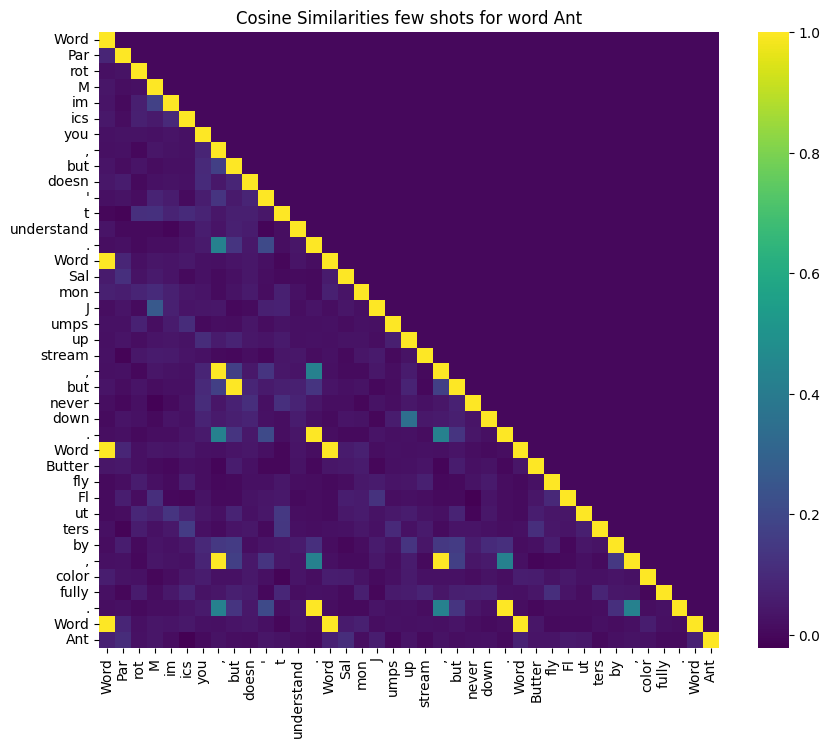

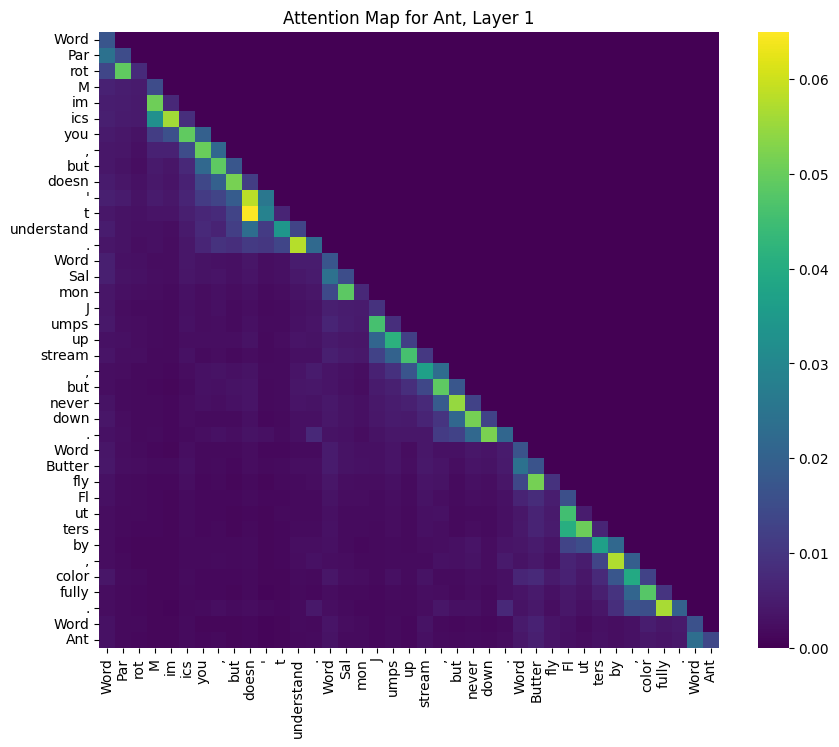

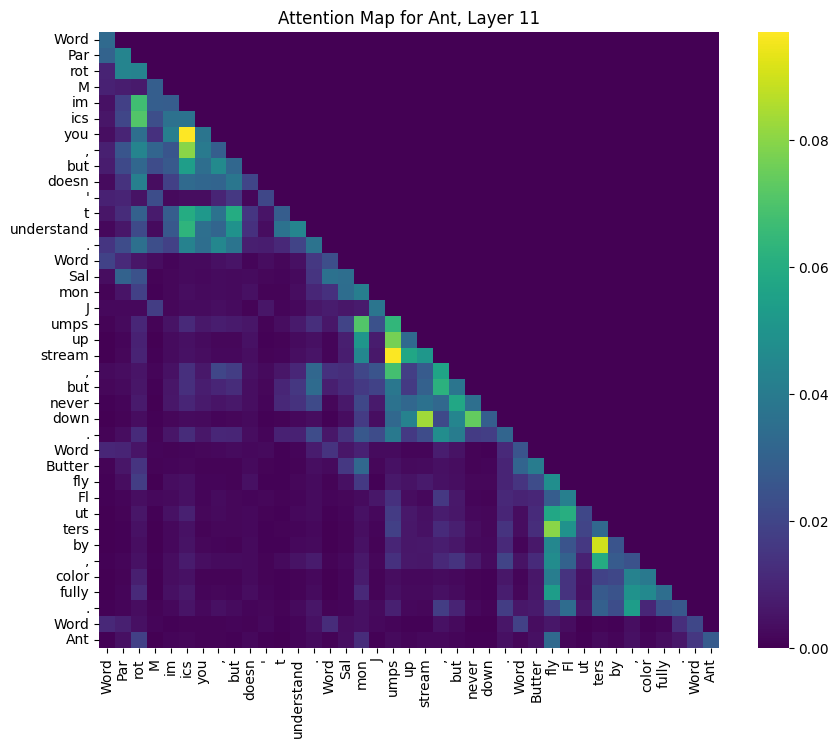

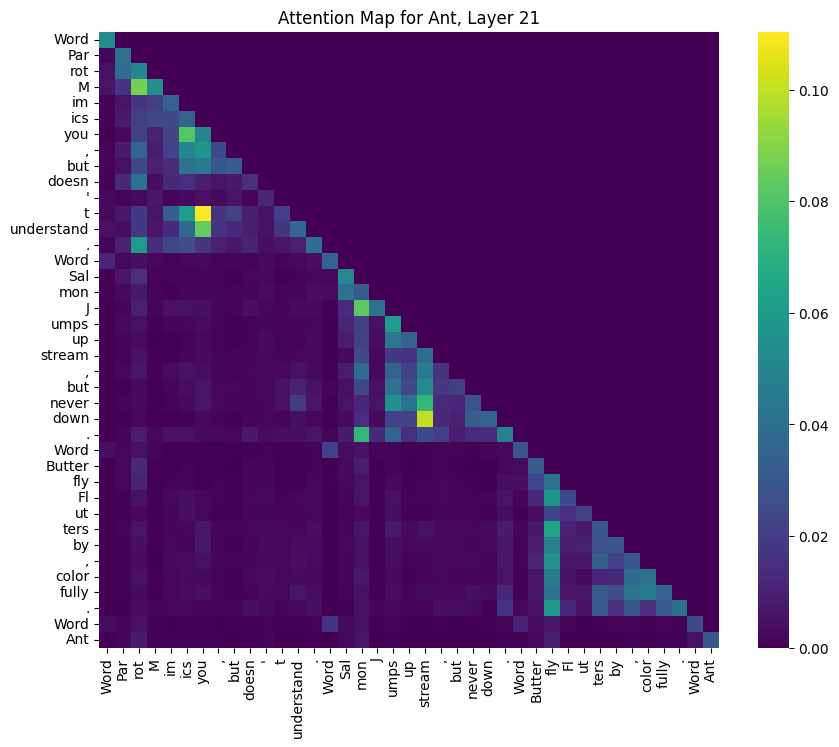

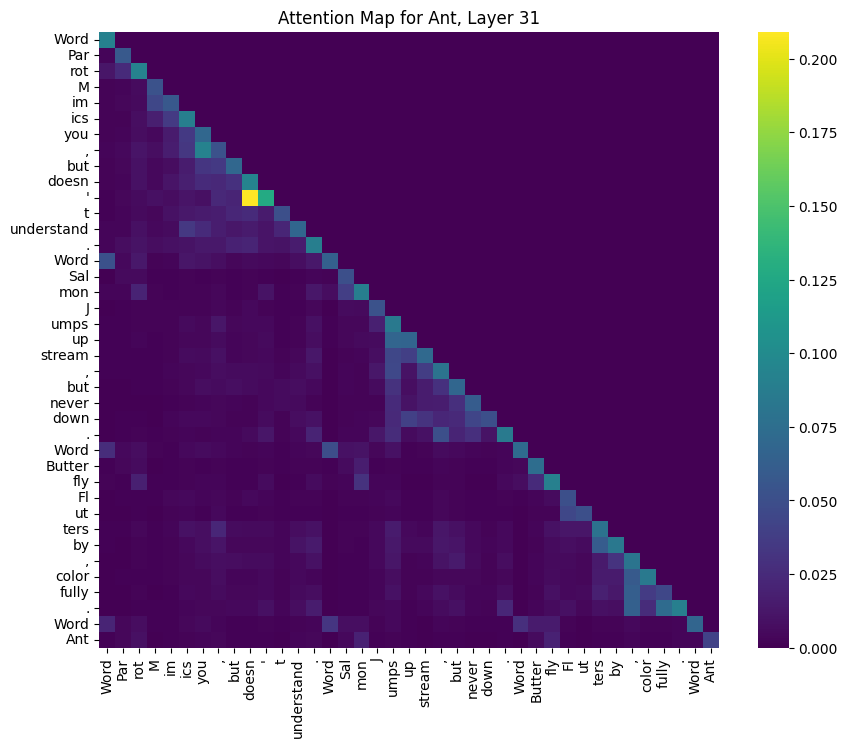


Input Text:  [INST] You have to generate a short descripton for the words from the category Animals. I will give you a word and you have to output a short description related to the word, which is engaging and challenging. Just give one answer, marking the end with a #. [/INST]Ok [INST] Word: Seal [/INST]Claps on land, swims in seas.# [INST] Word: Beaver [/INST]Nature's engineer, dam builder.# [INST] Word: Turtle [/INST]Carries its home, slow and steady.# [INST] Word: Cat [/INST]

-----Example 2----

Word: Cat

Generated Clue:  Silent hunter, purrs in affection.


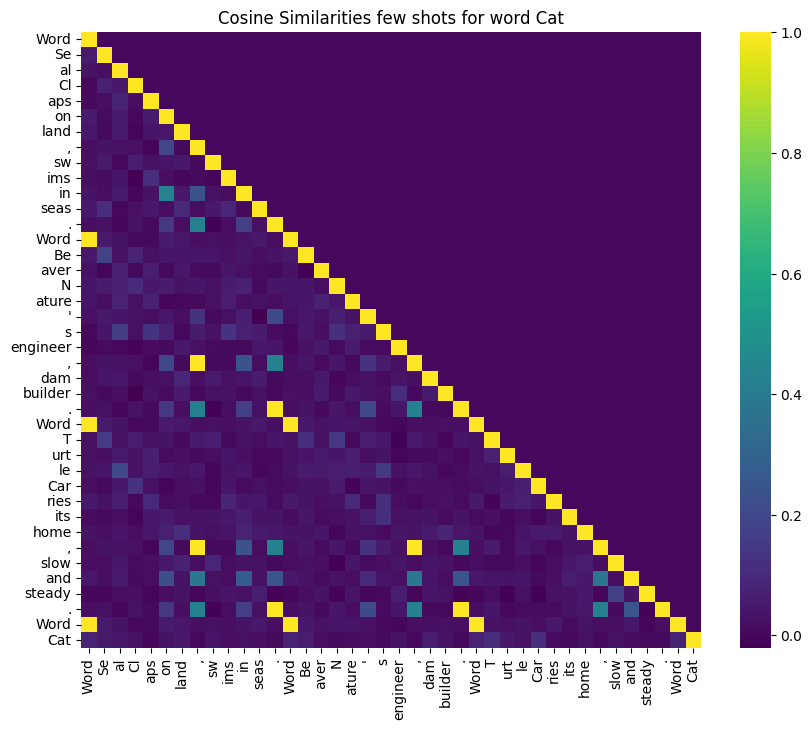

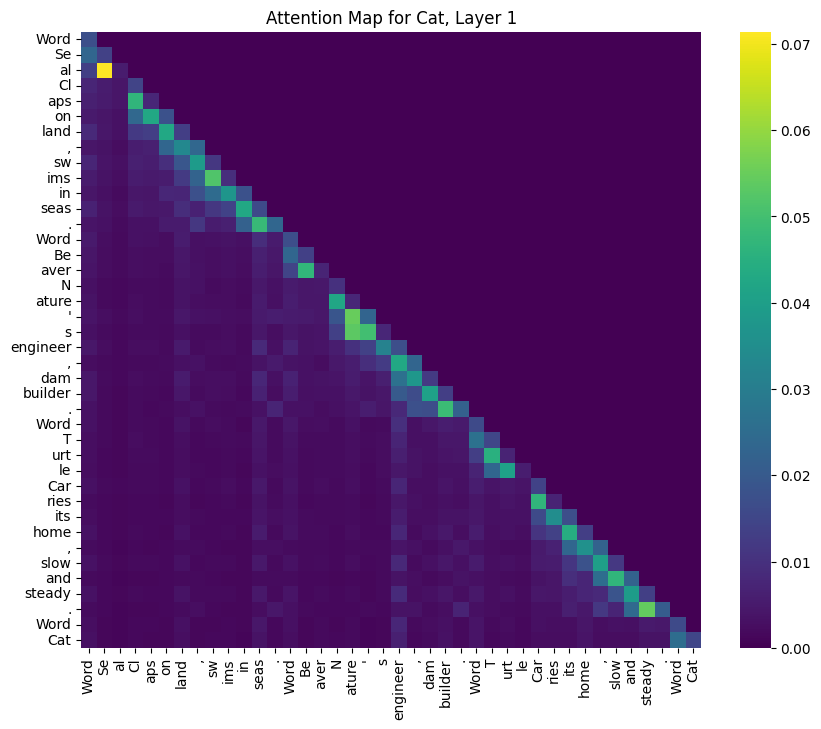

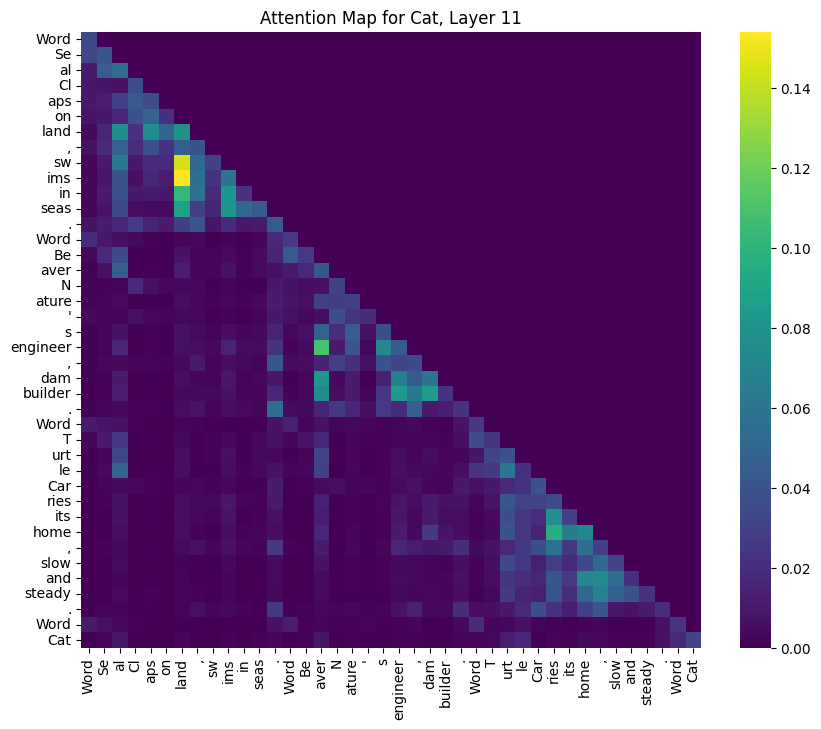

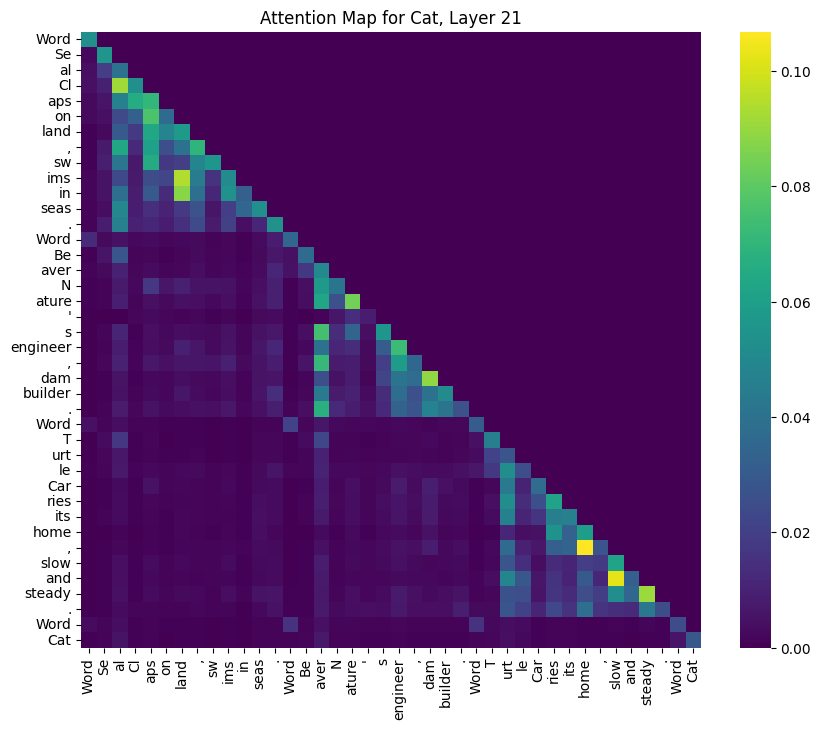

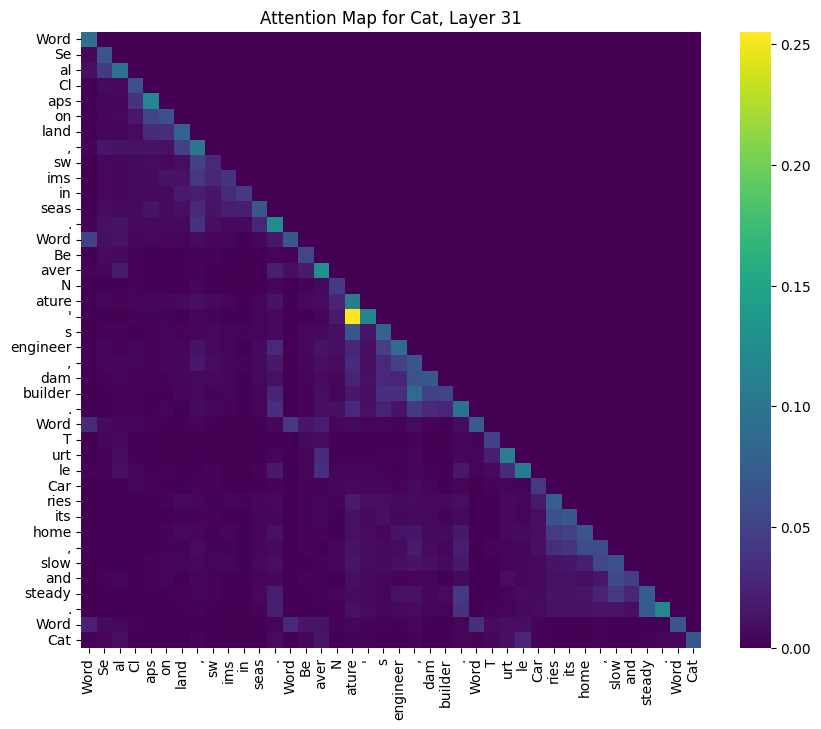


Input Text:  [INST] You have to generate a short descripton for the words from the category Animals. I will give you a word and you have to output a short description related to the word, which is engaging and challenging. Just give one answer, marking the end with a #. [/INST]Ok [INST] Word: Lion [/INST]King in the jungle, but not in chess.# [INST] Word: Elephant [/INST]Never forgets, with ears bigger than its face.# [INST] Word: Tiger [/INST]Stripes that can't be changed, unlike clothes.# [INST] Word: Rat [/INST]

-----Example 3----

Word: Rat

Generated Clue:  Small, quick, and often sneaky, they scamper in the night.


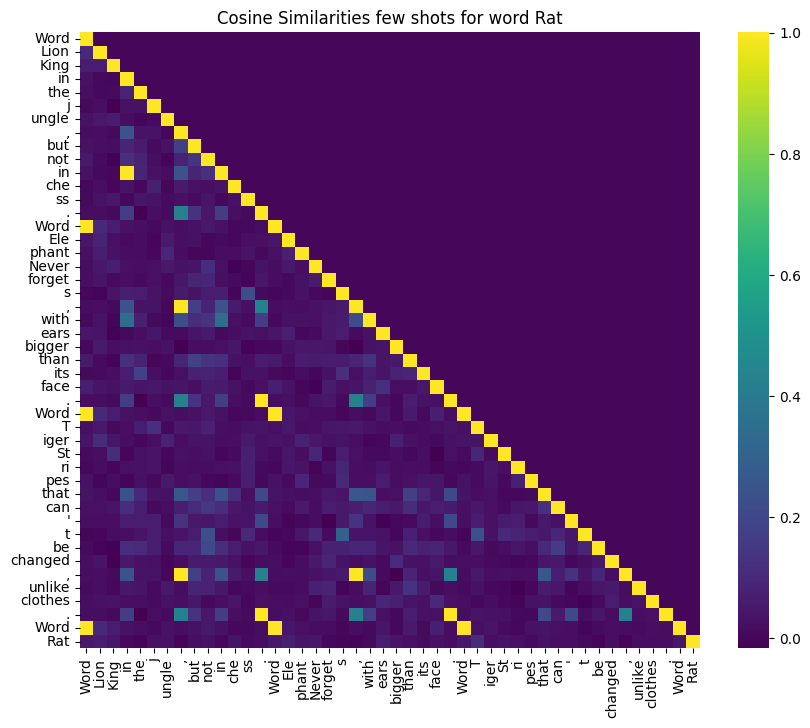

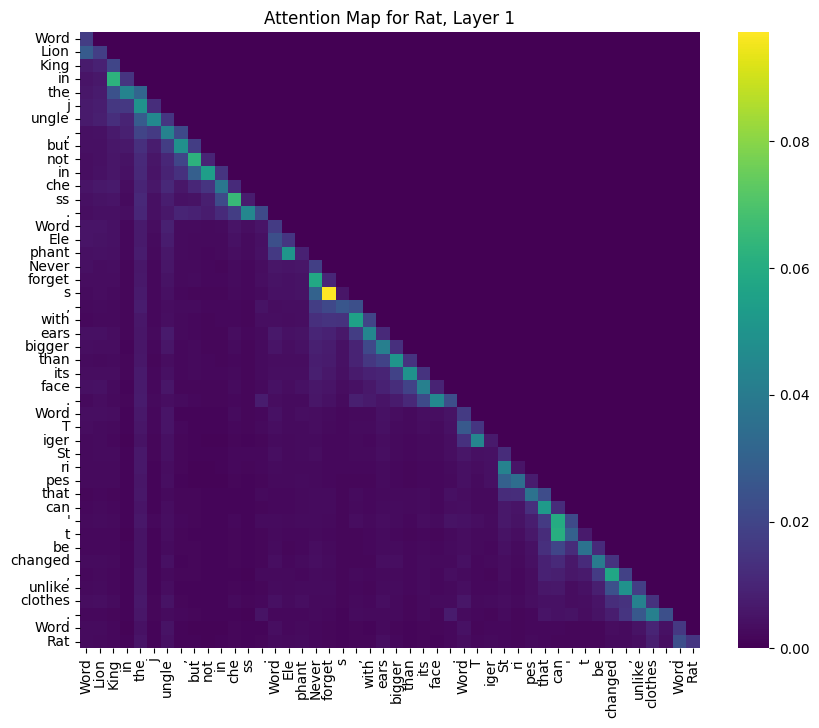

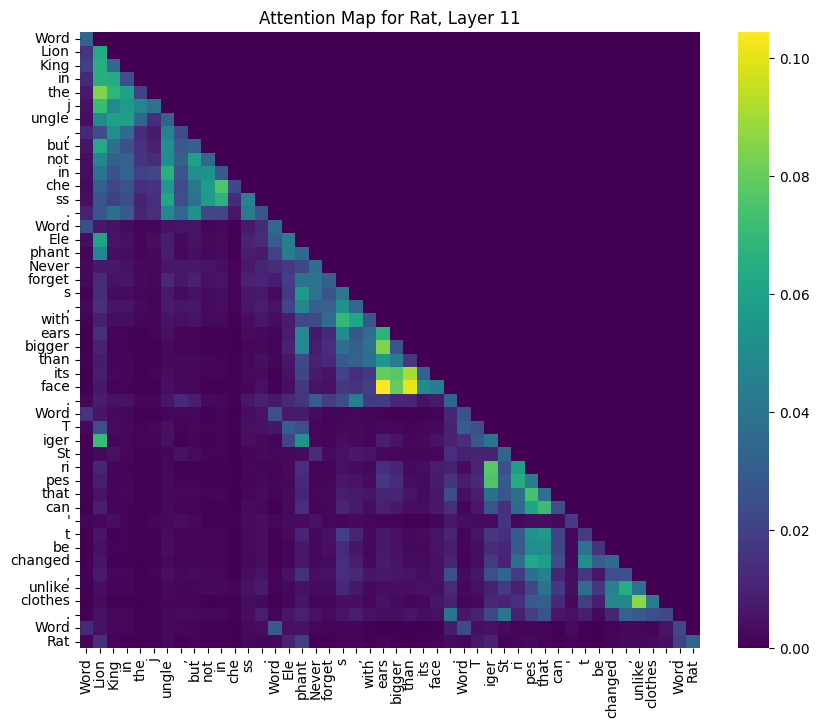

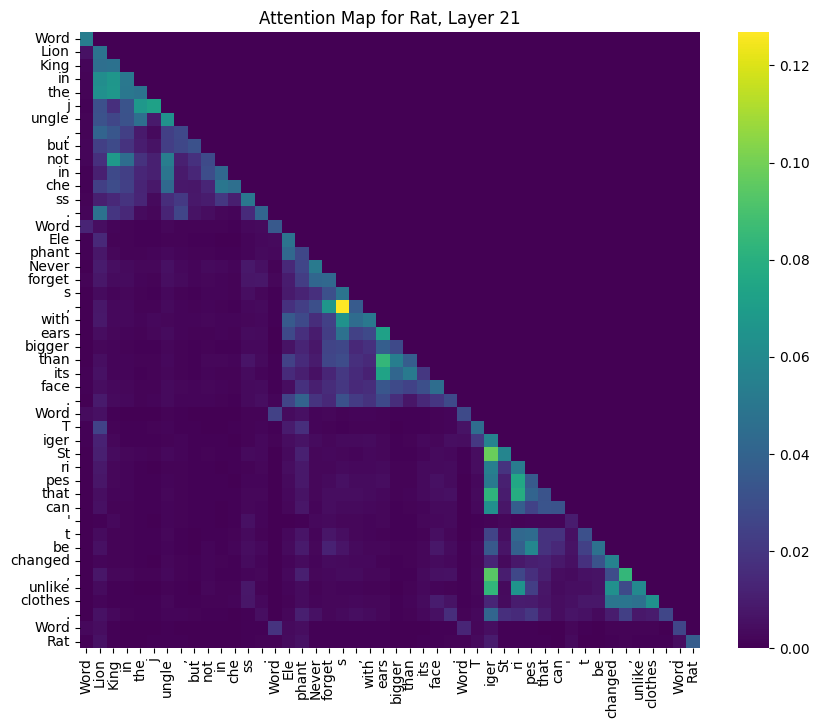

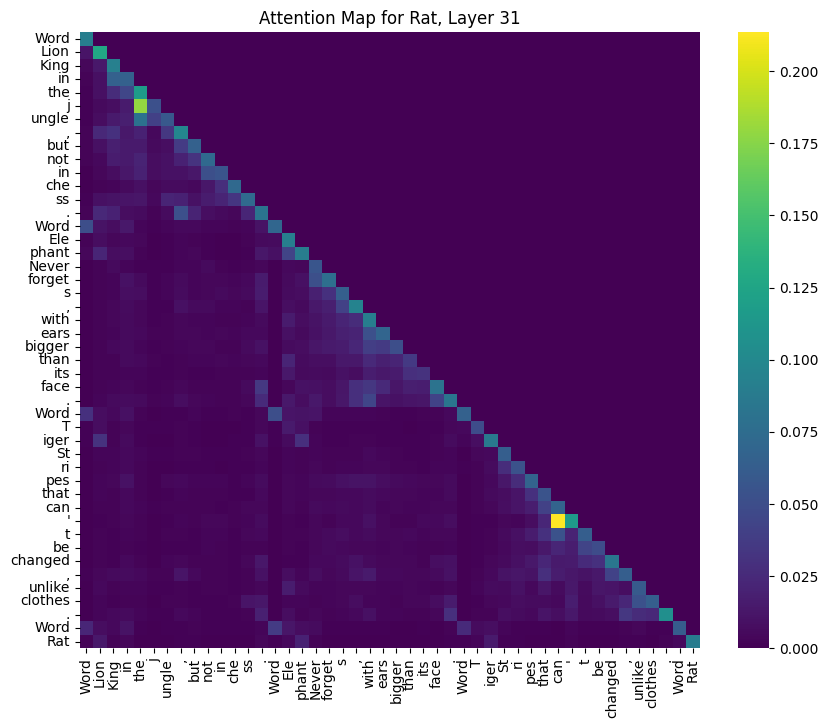


Input Text:  [INST] You have to generate a short descripton for the words from the category Animals. I will give you a word and you have to output a short description related to the word, which is engaging and challenging. Just give one answer, marking the end with a #. [/INST]Ok [INST] Word: Rat [/INST]Urban explorer, cheese aficionado.# [INST] Word: Elephant [/INST]Never forgets, with ears bigger than its face.# [INST] Word: Beaver [/INST]Nature's engineer, dam builder.# [INST] Word: Emu [/INST]

-----Example 4----

Word: Emu

Generated Clue:  1.6-foot-tall flightless bird, Australian pride.


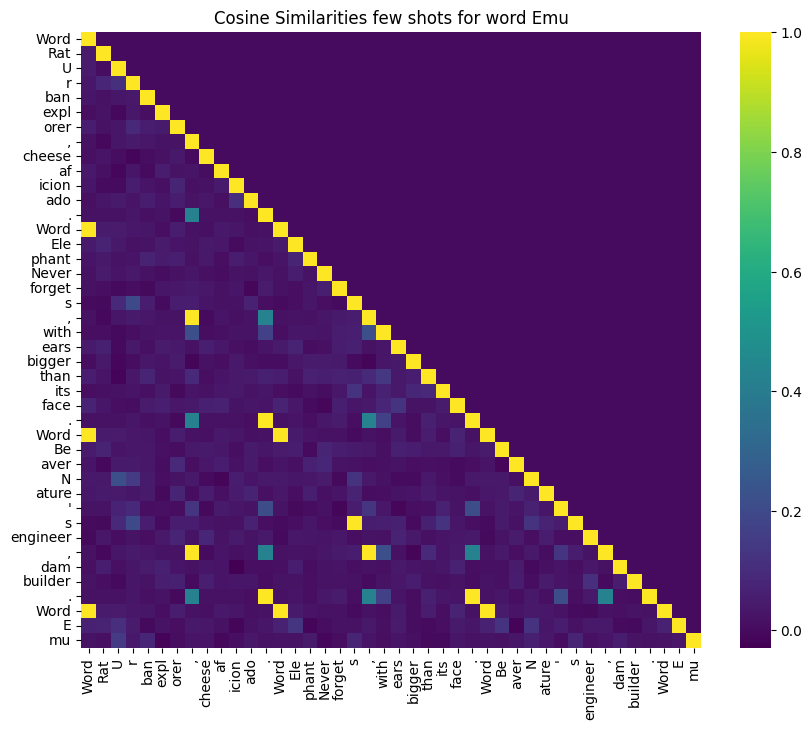

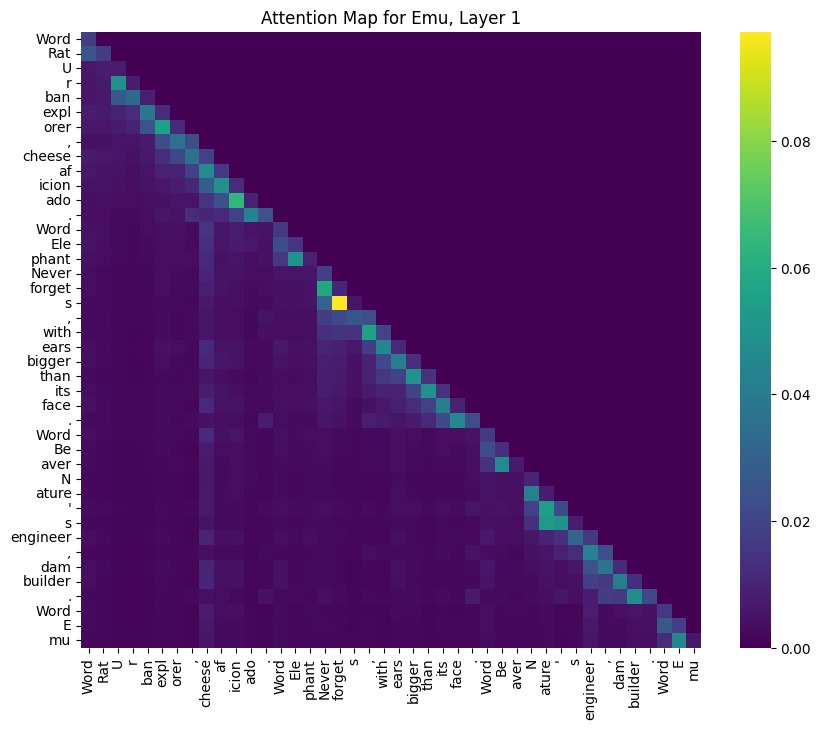

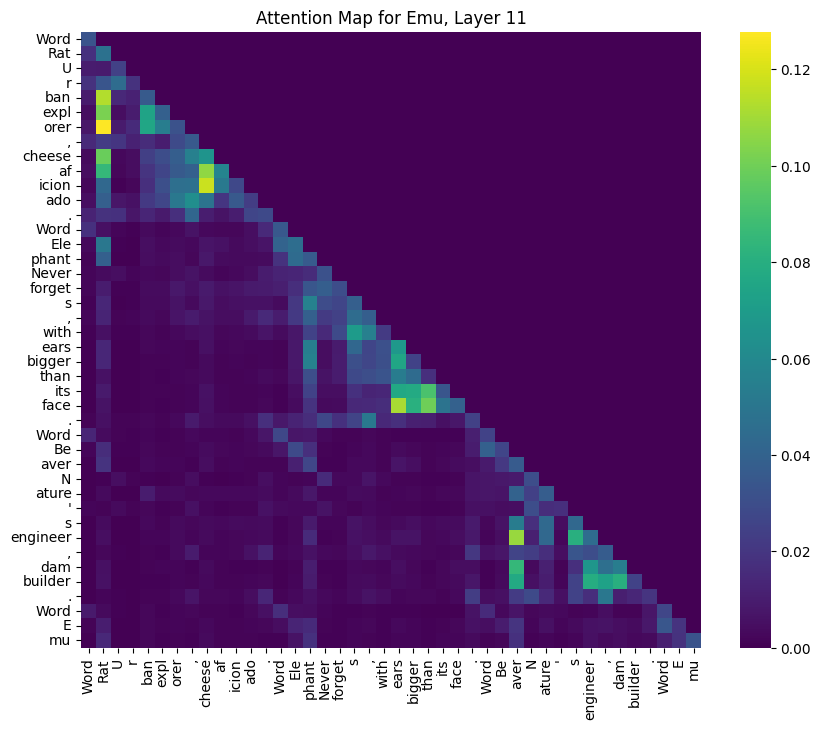

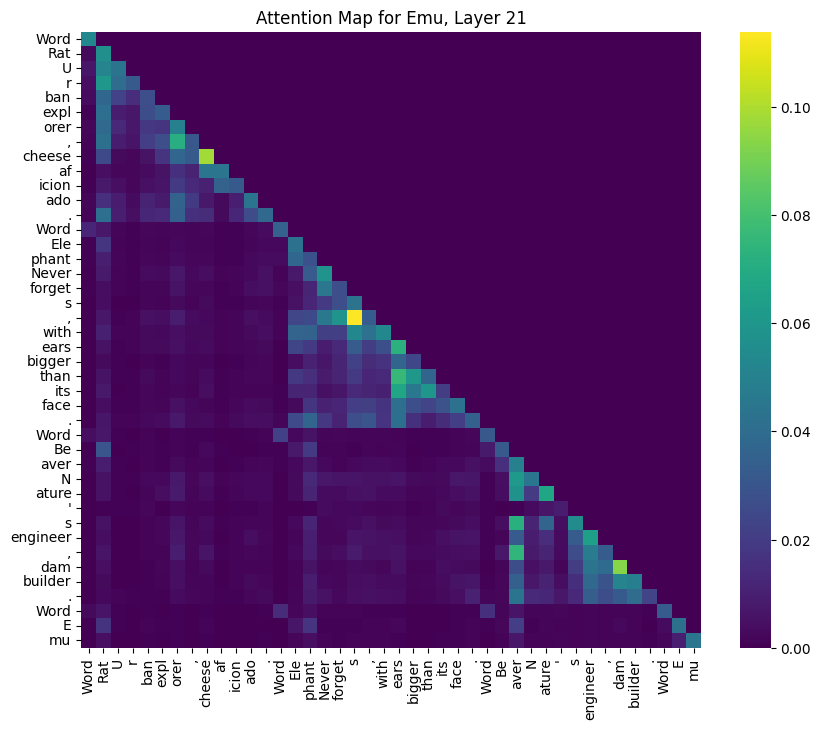

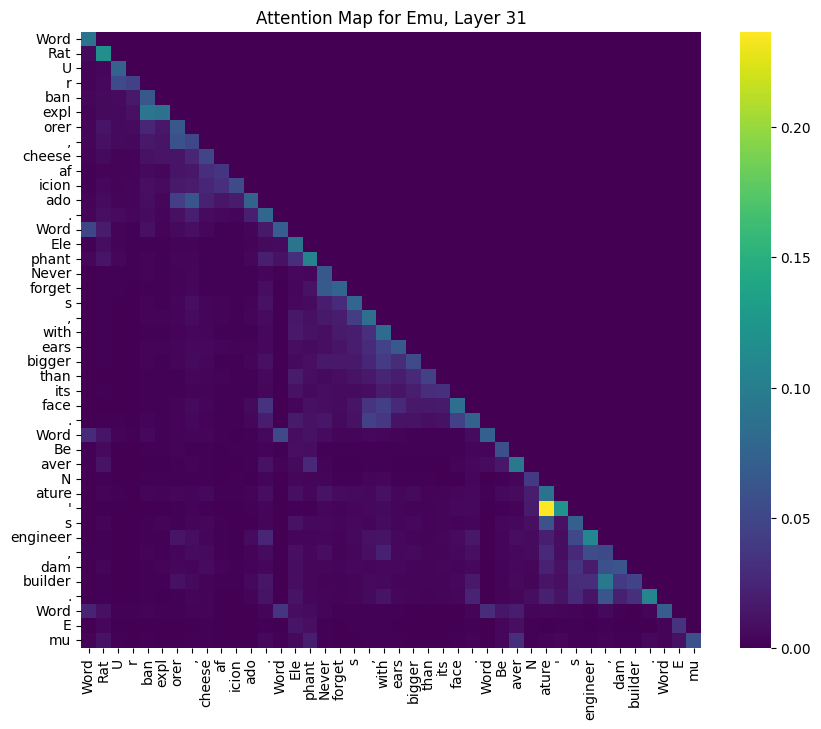


Input Text:  [INST] You have to generate a short descripton for the words from the category Animals. I will give you a word and you have to output a short description related to the word, which is engaging and challenging. Just give one answer, marking the end with a #. [/INST]Ok [INST] Word: Squirrel [/INST]Nut collector, tree acrobat.# [INST] Word: Swan [/INST]Grace on water, beauty in flight.# [INST] Word: Whale [/INST]Giant of the sea, but gentle in spirit.# [INST] Word: Fox [/INST]

-----Example 5----

Word: Fox

Generated Clue:  Cunning and elusive, with a bushy tail and sly grin.


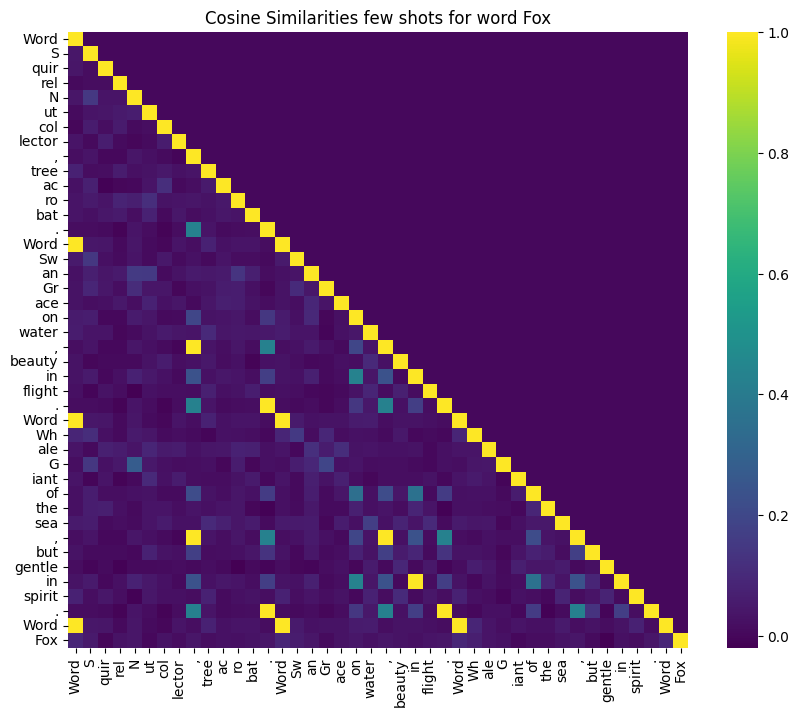

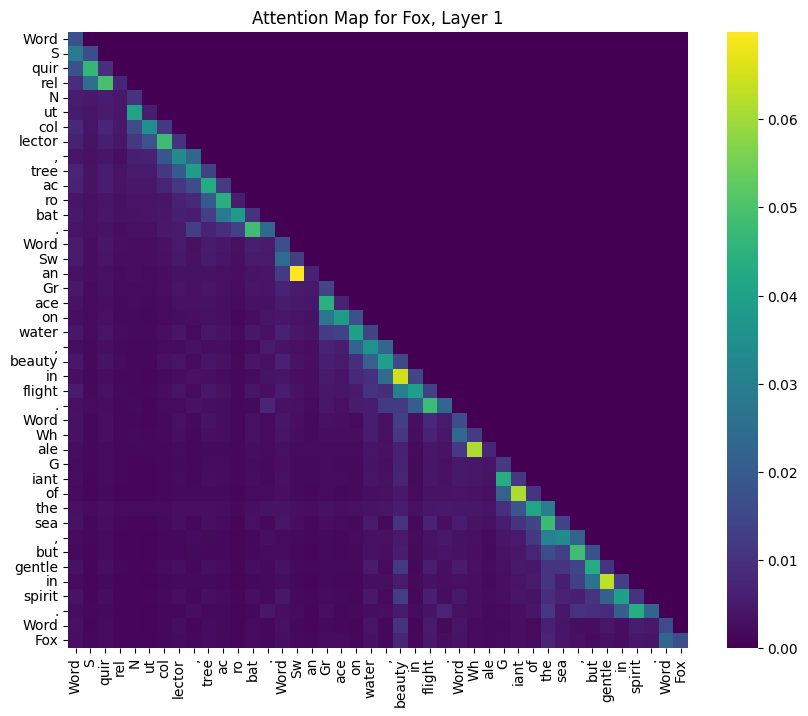

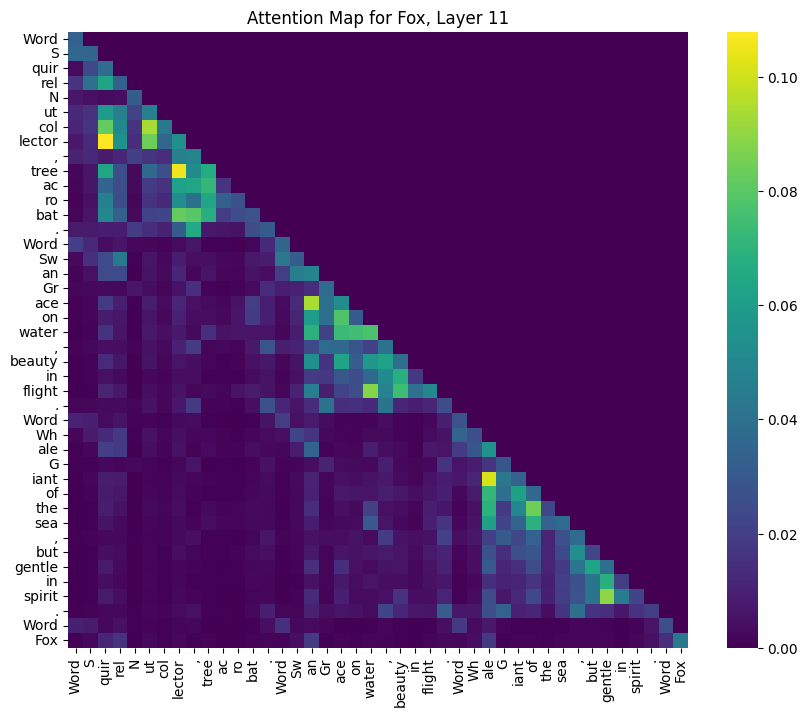

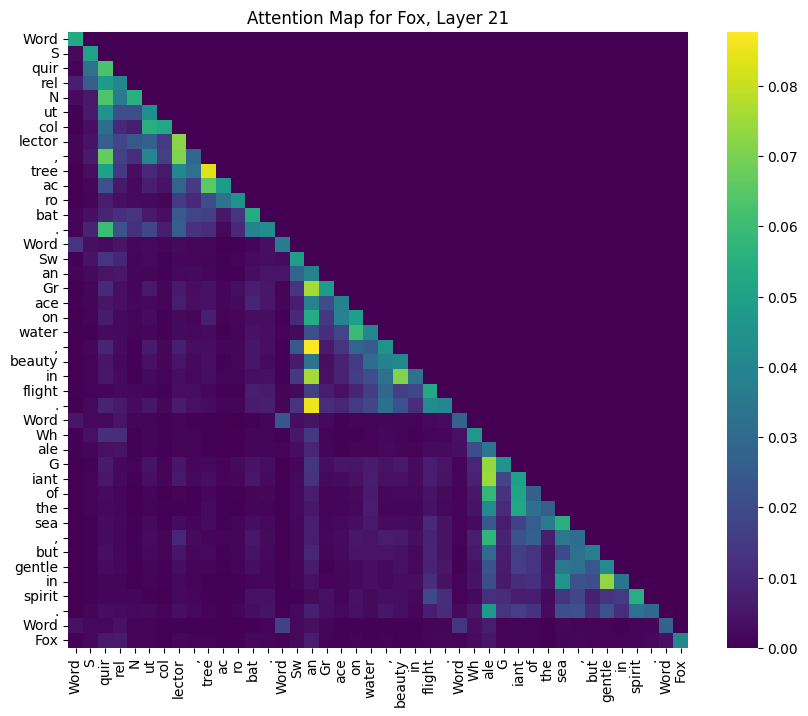

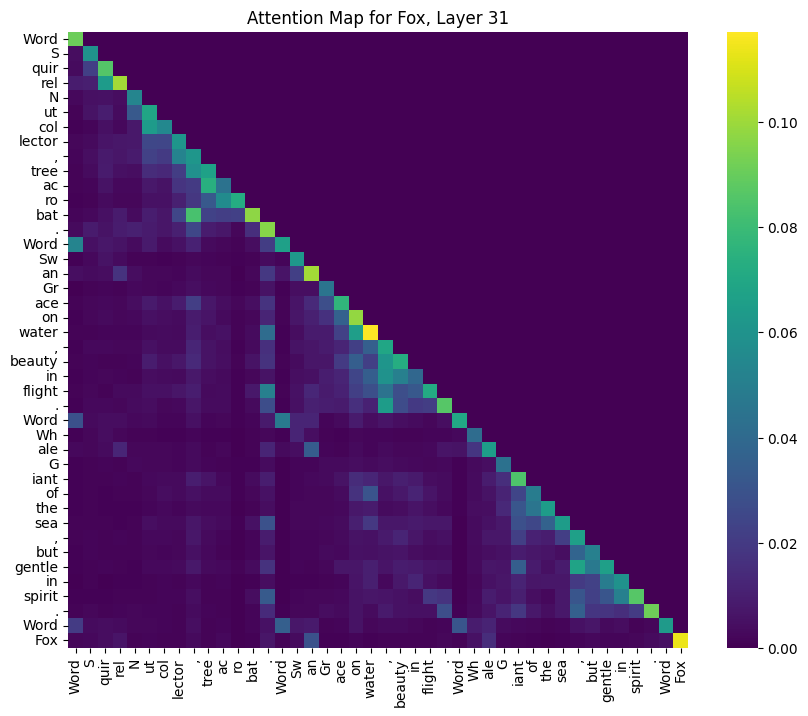


Input Text:  [INST] You have to generate a short descripton for the words from the category Animals. I will give you a word and you have to output a short description related to the word, which is engaging and challenging. Just give one answer, marking the end with a #. [/INST]Ok [INST] Word: Kangaroo [/INST]An Aussie boxer with a built-in pouch.# [INST] Word: Fox [/INST]Clever in color, orange in the woods.# [INST] Word: Seal [/INST]Claps on land, swims in seas.# [INST] Word: Cow [/INST]

-----Example 6----

Word: Cow

Generated Clue:  Grazing giant with a gentle moo.


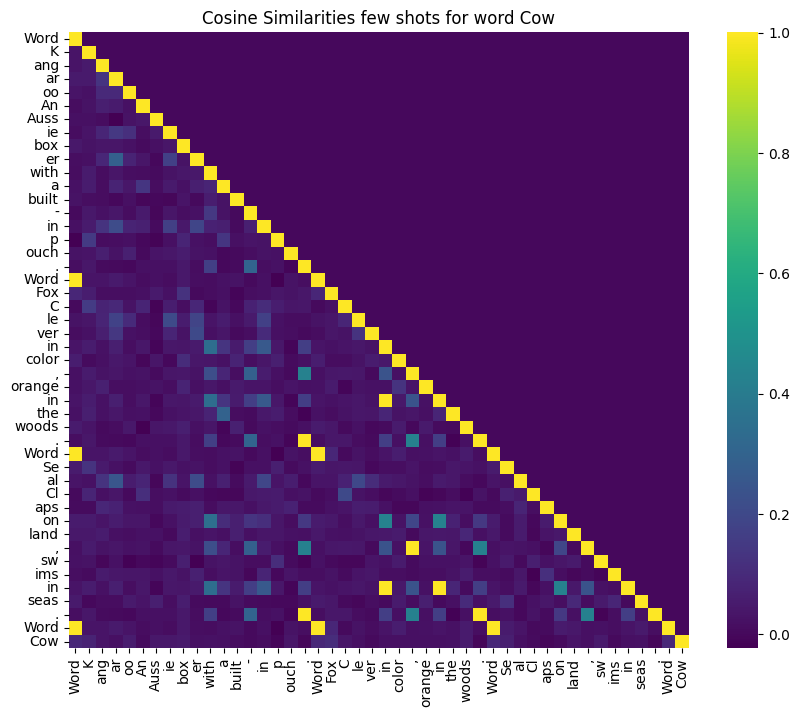

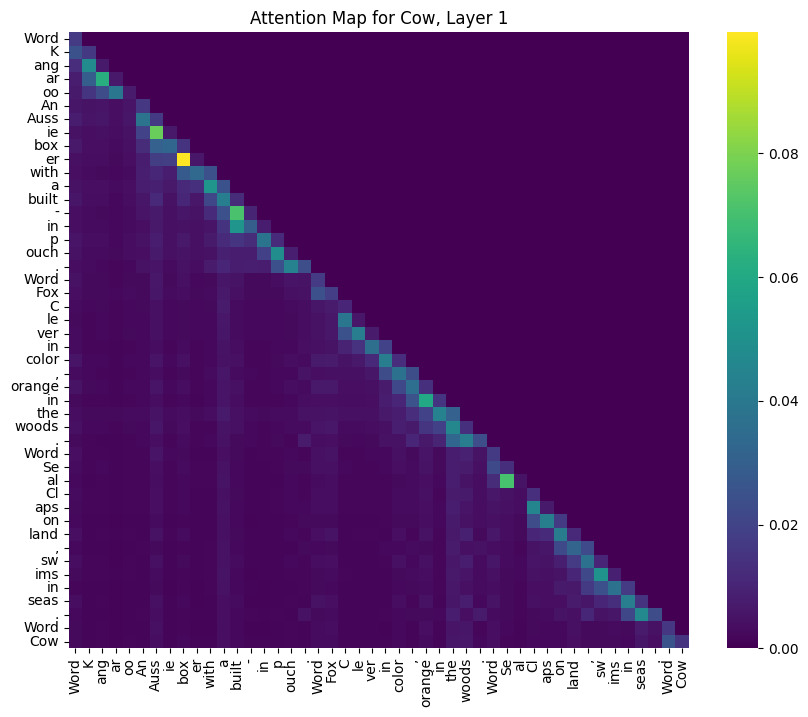

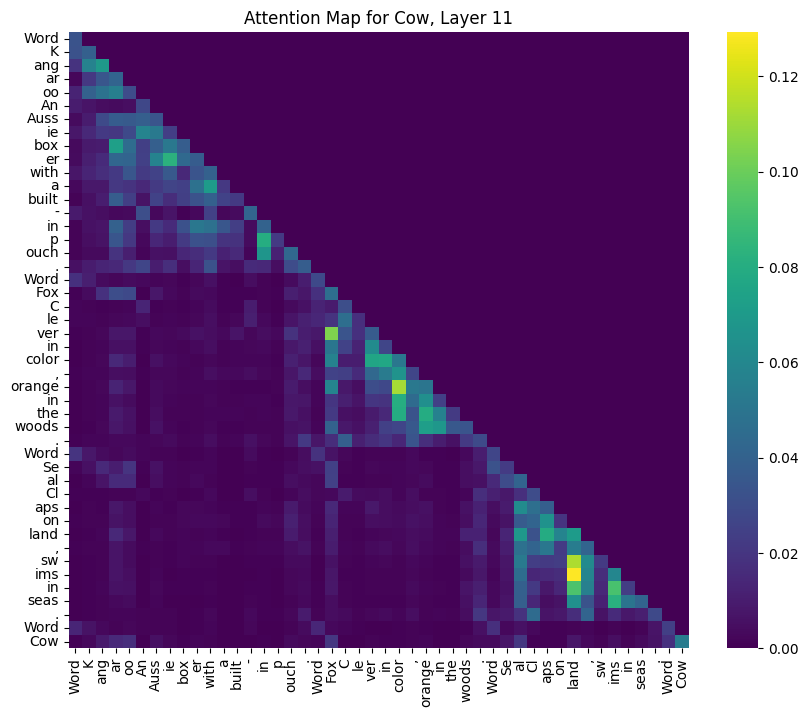

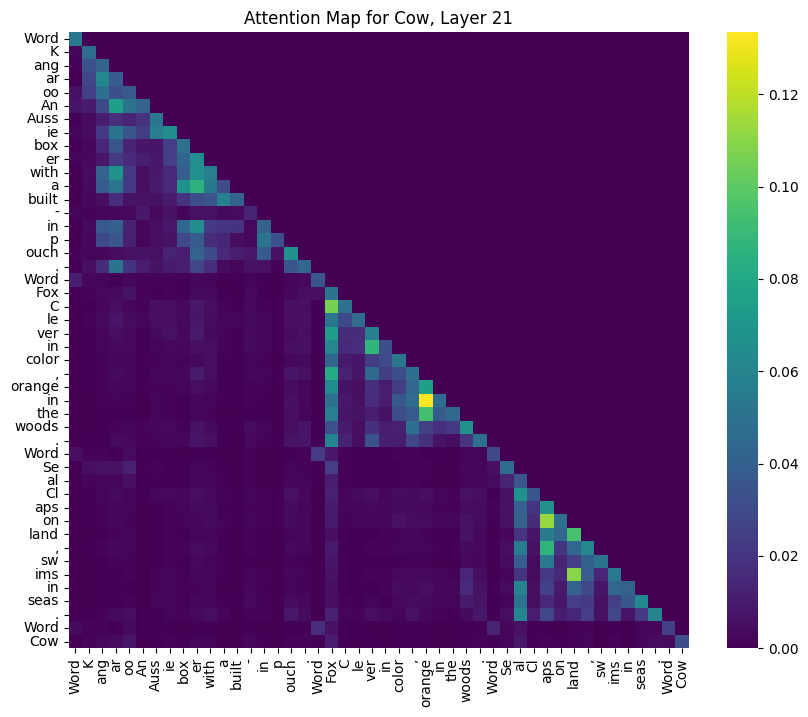

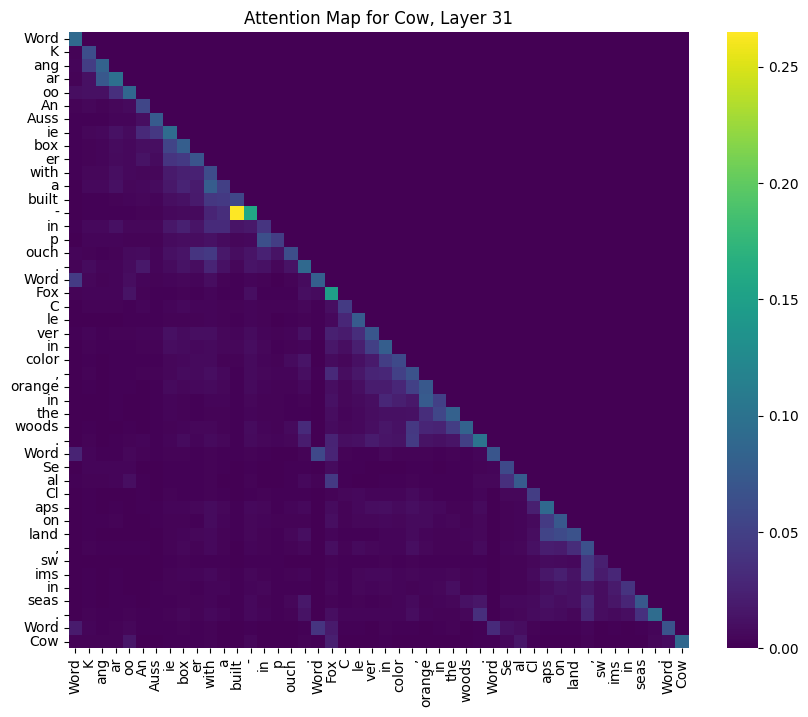


Input Text:  [INST] You have to generate a short descripton for the words from the category Animals. I will give you a word and you have to output a short description related to the word, which is engaging and challenging. Just give one answer, marking the end with a #. [/INST]Ok [INST] Word: Hippo [/INST]Opens wide, but doesn't eat big.# [INST] Word: Seal [/INST]Claps on land, swims in seas.# [INST] Word: Snake [/INST]Slithers in silence, no legs required.# [INST] Word: Bee [/INST]

-----Example 7----

Word: Bee

Generated Clue: Zipping through the air, pollen-laden, making honey, sweet delight.


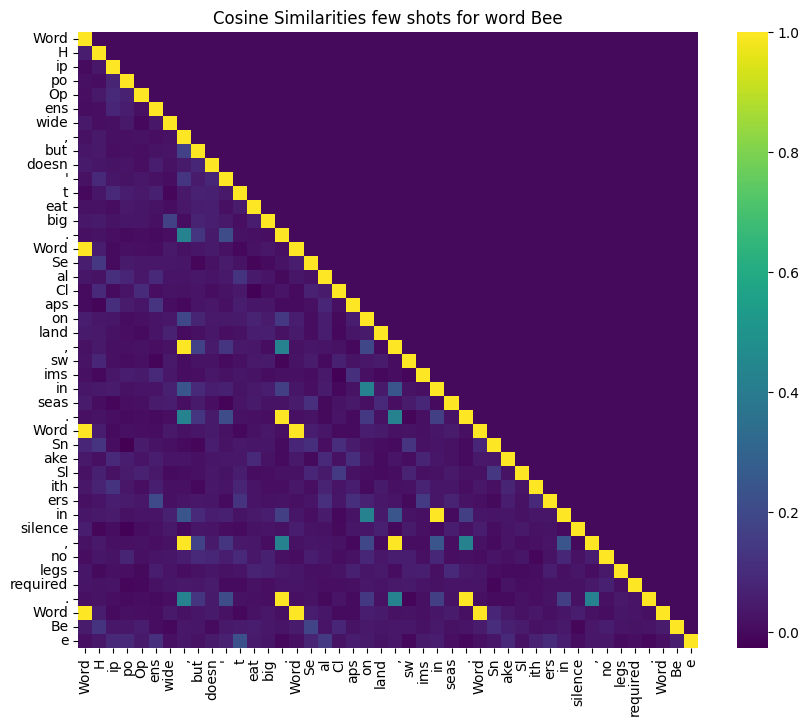

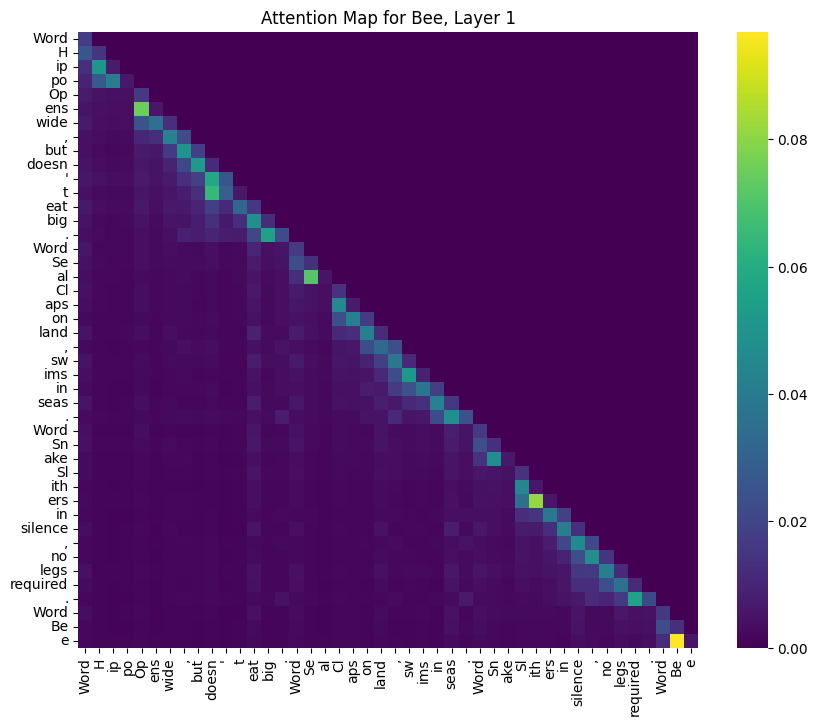

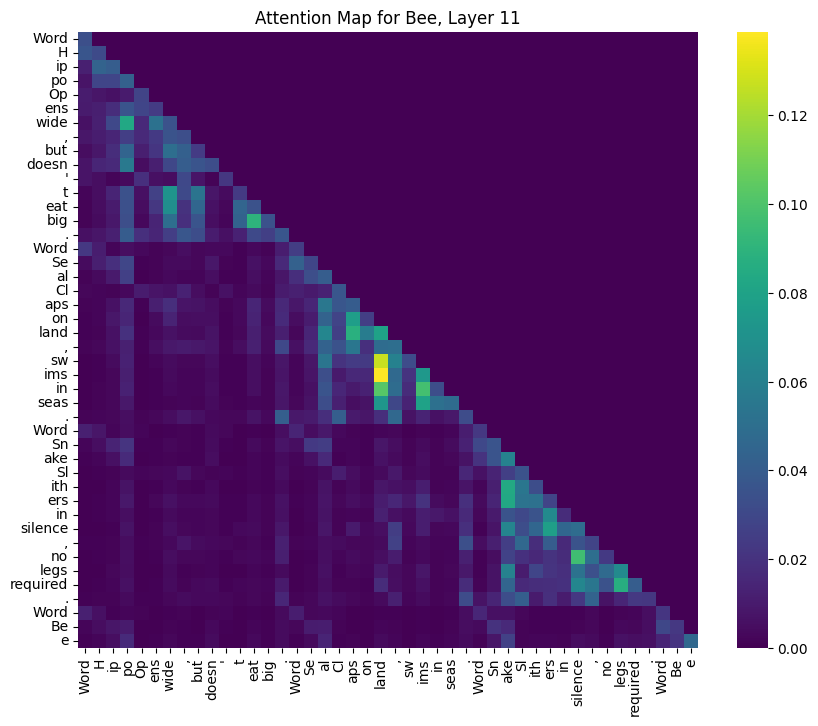

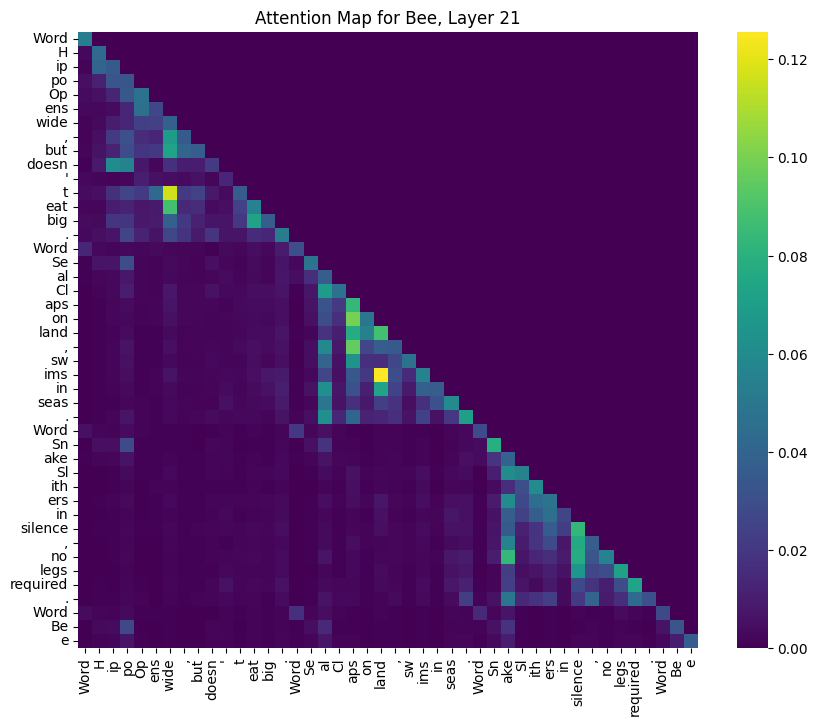

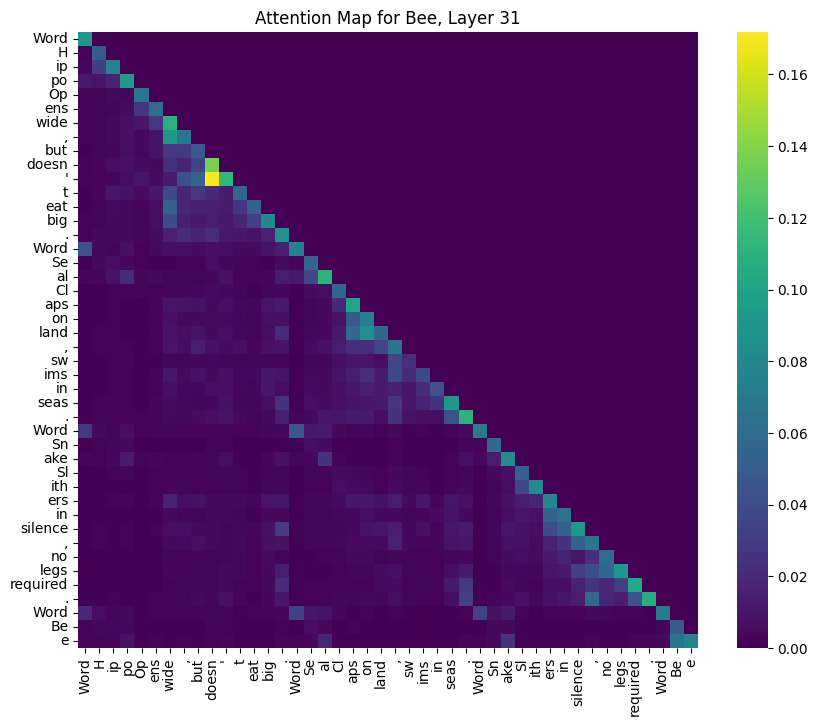


Input Text:  [INST] You have to generate a short descripton for the words from the category Animals. I will give you a word and you have to output a short description related to the word, which is engaging and challenging. Just give one answer, marking the end with a #. [/INST]Ok [INST] Word: Lion [/INST]King in the jungle, but not in chess.# [INST] Word: Pigeon [/INST]City dweller, feathered messenger.# [INST] Word: Otter [/INST]Plays in water, holds hands in sleep.# [INST] Word: Owl [/INST]

-----Example 8----

Word: Owl

Generated Clue:  Silent hunter of the night, with large, wise, and watchful eyes.


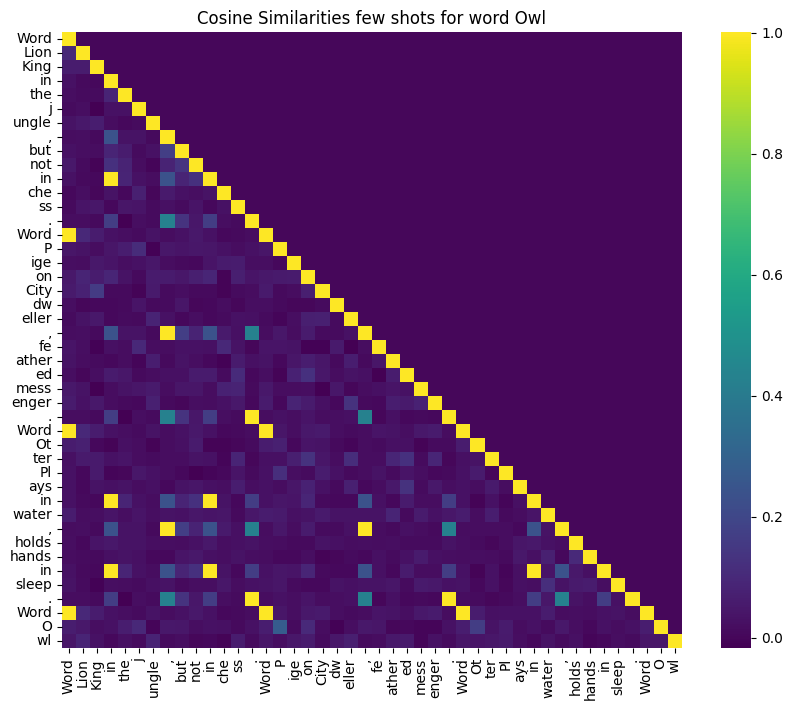

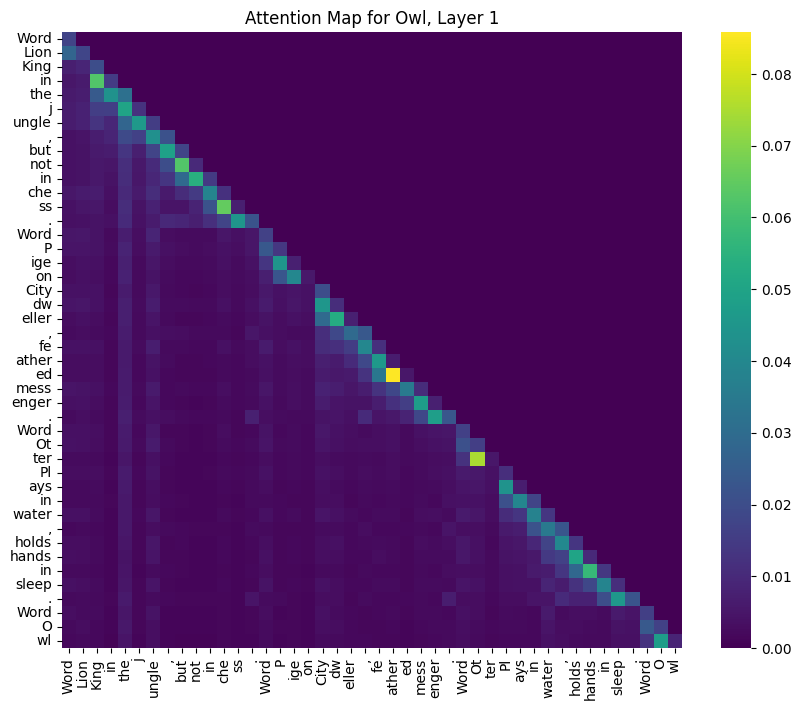

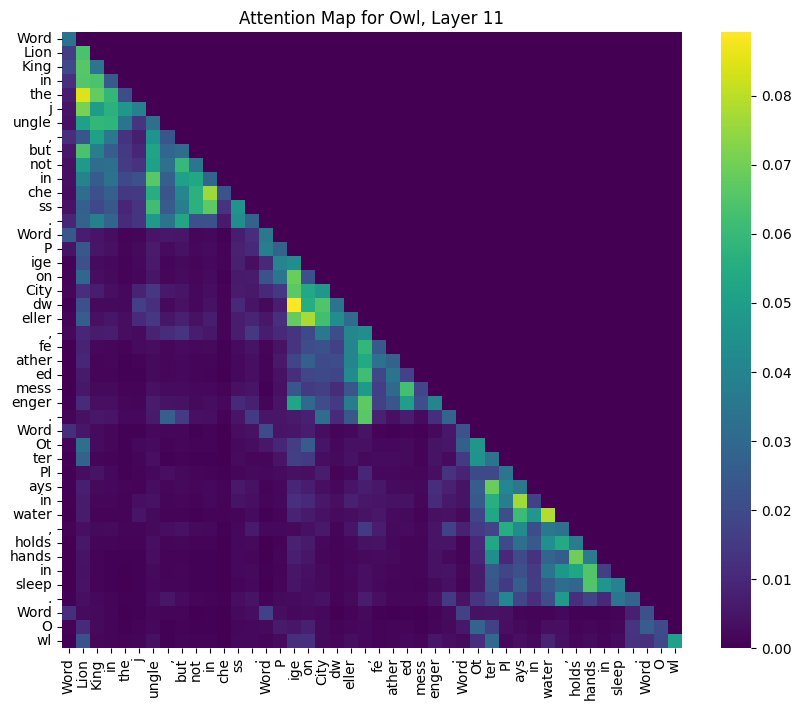

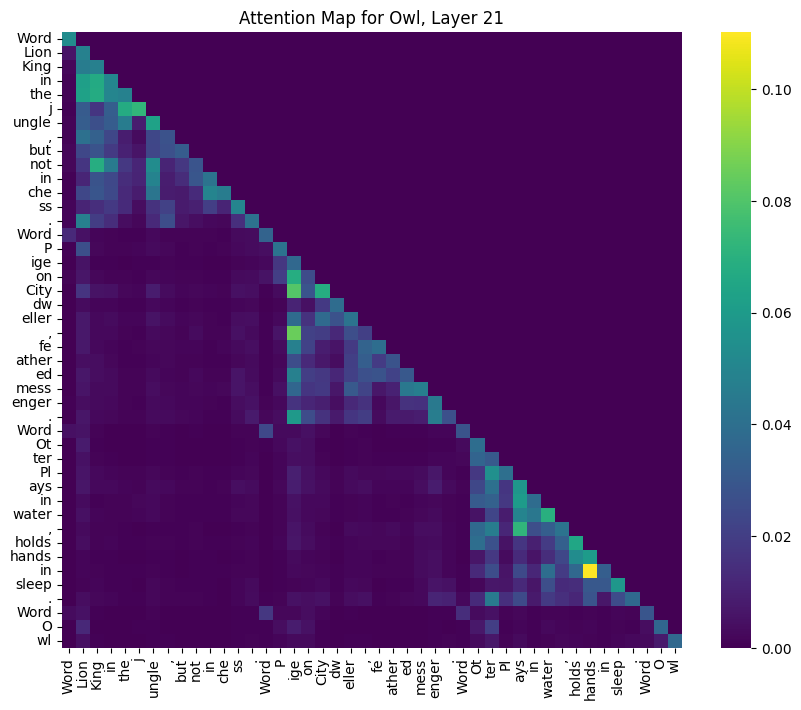

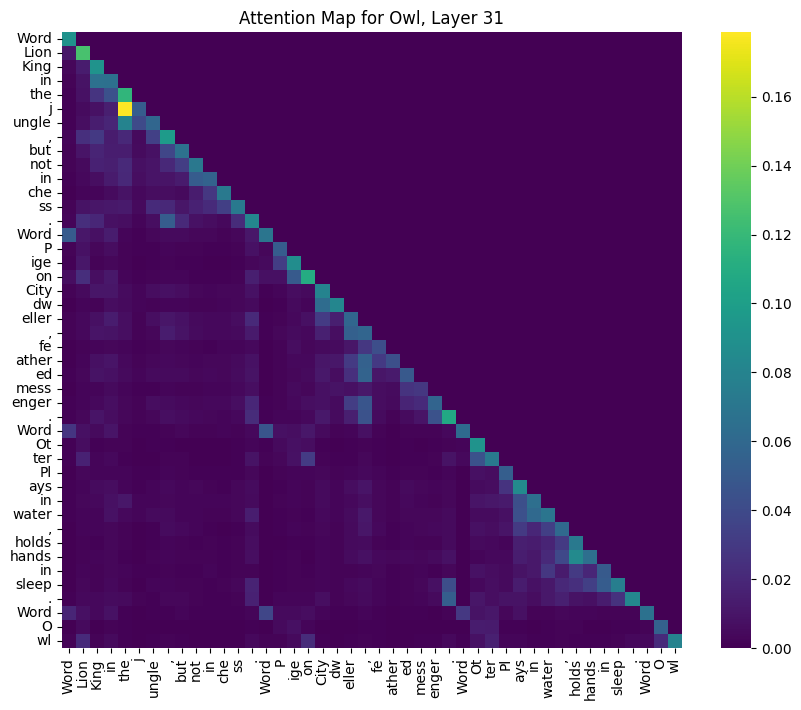


Input Text:  [INST] You have to generate a short descripton for the words from the category Animals. I will give you a word and you have to output a short description related to the word, which is engaging and challenging. Just give one answer, marking the end with a #. [/INST]Ok [INST] Word: Seal [/INST]Claps on land, swims in seas.# [INST] Word: Wolf [/INST]Howls at the moon, but dines on the ground.# [INST] Word: Rabbit [/INST]Hops along, ears first.# [INST] Word: Dog [/INST]

-----Example 9----

Word: Dog

Generated Clue: Man's best friend, tail wagging, loyal and true.


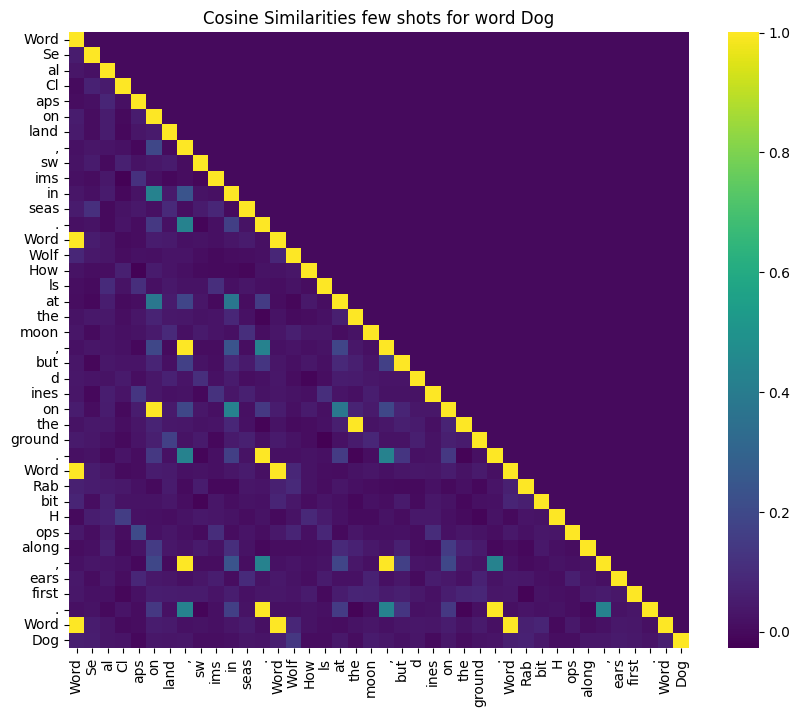

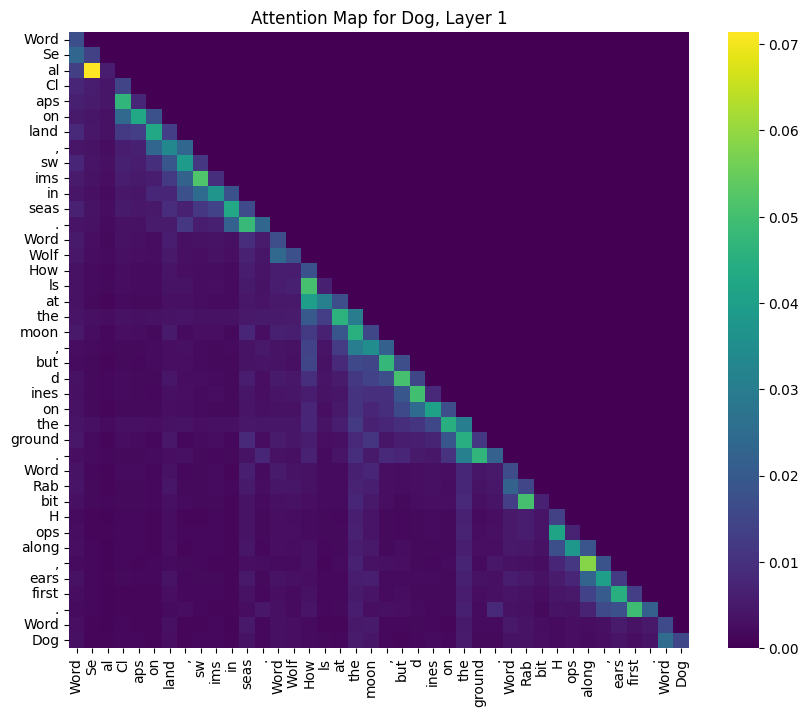

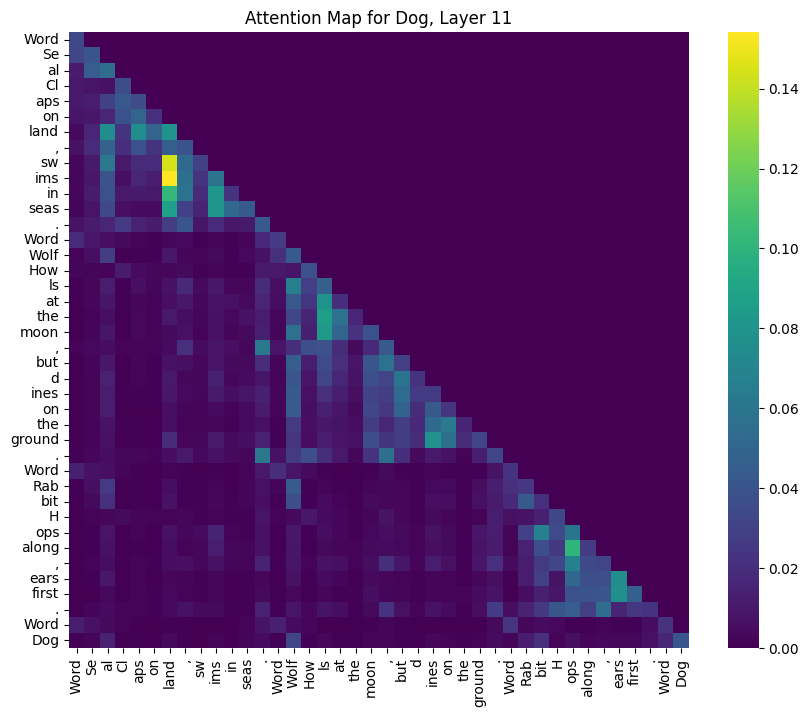

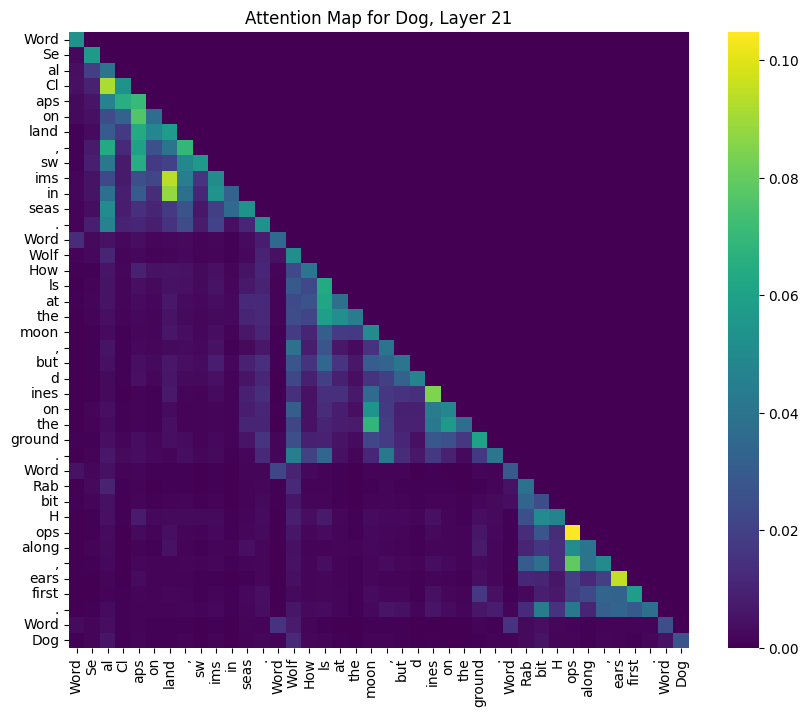

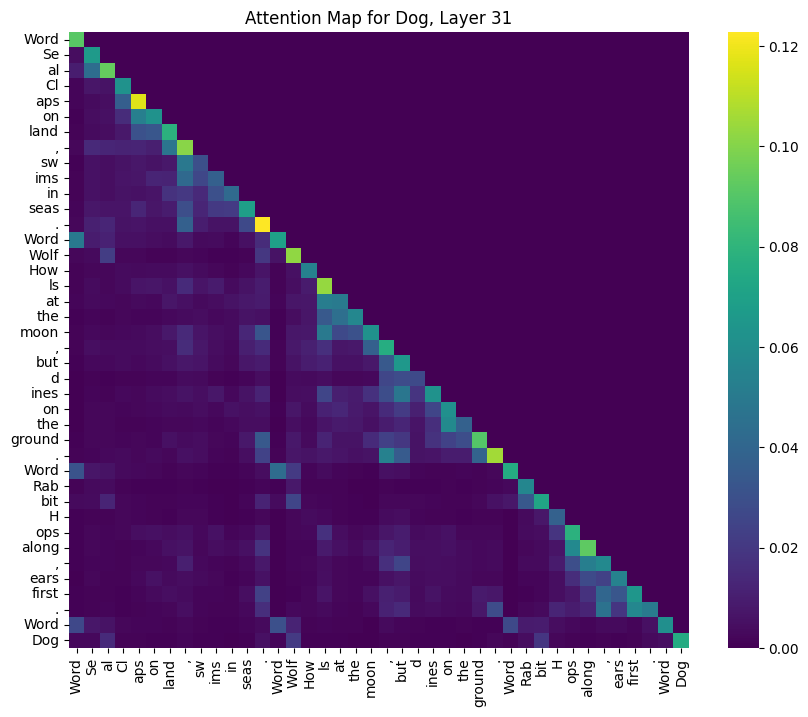

In [123]:
N_PROMPTS = 3
MODEL = model # "mistralai/Mistral-7B-Instruct-v0.2"
TOKENIZER = tokenizer
INPUT_WORDS_FILE_PATH = "animals_dummy_words.txt"
INPUT_WORDS_CLUES_FILE_PATH = "animals_dummy_words_clues_small.csv"
OUTPUT_WORDS_CLUES_FILE_PATH = "words_generated_clues.csv"
CATEGORY = "Animals"

PROMPT_PREFIX = f"You have to generate a short descripton for the words from the category {CATEGORY}. I will give you a word and you have to output a short description " + \
                "related to the word, which is engaging and challenging. Just give one answer, marking the end with a #."

PRINT_OUTPUT = True

def get_embedding():
    for name, param in model.named_parameters():
        if name == "model.embed_tokens.weight":
            return param
        
embedding = get_embedding()

generate(N_PROMPTS, MODEL, TOKENIZER, INPUT_WORDS_FILE_PATH, INPUT_WORDS_CLUES_FILE_PATH, OUTPUT_WORDS_CLUES_FILE_PATH, PROMPT_PREFIX, PRINT_OUTPUT, device, embedding)


In [15]:
STATS_SAVE_PATH = "singular_value_statistics/"

def get_qkv_matrix_from_layer_l(model, l):
    print(f"Extracting Layer {l}")
    tag = f".{l}" # ".{l}"
    q_matix, k_matrix, v_matrix = None, None, None
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and isinstance(module.weight, torch.Tensor):
            if f"{tag}.self_attn.q" in name:
                q_matix = module.weight.cpu()
            elif f"{tag}.self_attn.k" in name:
                #module.weight.data = module.weight * alpha
                k_matrix = module.weight.cpu()
            elif f"{tag}.self_attn.v" in name:
                v_matrix = module.weight.cpu()
    return q_matix.to(dtype=torch.float32), k_matrix.to(dtype=torch.float32), v_matrix.to(dtype=torch.float32)

def get_mlp_up_down_matrix_from_layer_l(model, l):
    print(f"Extracting Layer {l}")
    tag = f".{l}" # ".{l}"
    up_matrix, down_matrix = None, None
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and isinstance(module.weight, torch.Tensor):
            if f"{tag}.mlp.up_proj" in name:
                up_matrix = module.weight.cpu()
            elif f"{tag}.mlp.down_proj" in name:
                down_matrix = module.weight.cpu()
    return up_matrix.to(dtype=torch.float32), down_matrix.to(dtype=torch.float32)

def get_svd(weight_matrix):
    U, D, Vh = torch.svd(weight_matrix.to(dtype=torch.float32))
    return U, D, Vh


def scale_matrix(model, module_name, alpha = 1., beta = 0.):
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and isinstance(module.weight, torch.Tensor):
            if module_name in name:
                module.weight.data = module.weight * alpha + beta

def change_svd_matrix(model, module_name, mean = 0., std = 0.2):
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and isinstance(module.weight, torch.Tensor):
            if module_name in name:
                U, D, Vh = torch.svd(module.weight.to(dtype=torch.float32))
                U2, D2, Vh2 = torch.svd(torch.normal(mean, std, module.weight.shape))
                new_weight = (torch.matmul(U, torch.matmul(torch.diag(D), Vh2.T)) * alpha).to(torch.float16)
                module.weight.data = new_weight

def print_singular_value_statistics(D, name):
    print(f"Average Squared Singular Value {name}", torch.mean(D**2).item())
    print(f"Variance Squared Singular Value {name}", torch.var(D**2).item())
    print(f"Largest Squared Singular Value {name}", torch.max(D**2).item())
    print(f"Largest 10 Squared Singular Values {name}", (D[:10] ** 2).detach().numpy())

def plot_singular_values_q_k_v(DQ, DK, DV, l, tag = "learned"):
    for factor, prefix in zip([1, 2], ["", "Squared"]):
        plt.figure()
        plt.plot((DQ ** factor).cpu().detach().numpy())
        plt.plot((DK ** factor).cpu().detach().numpy())
        plt.plot((DV ** factor).cpu().detach().numpy())
        plt.legend([f"{prefix} Singular Values Q", f"{prefix} Singular Values K", f"{prefix} Singular Values V"])
        plt.title(f"{prefix} Singular Values of Q, K and V in layer {l}")
        plt.savefig(f"{STATS_SAVE_PATH}singular_value{prefix} Singular Values of Q, K and V in layer {l}_{tag}")
        plt.show()

def plot_singular_values_mlp_up_down(DUp, DDown, l, tag = "learned"):
    for factor, prefix in zip([1, 2], ["", "Squared"]):
        plt.figure()
        plt.plot((DUp ** factor).cpu().detach().numpy())
        plt.plot((DDown ** factor).cpu().detach().numpy())
        plt.legend([f"{prefix} Singular Values MLP Up", f"{prefix} Singular Values MLP Down"])
        plt.title(f"{prefix} Singular Values of MLP Up and MLP Down in layer {l}")
        plt.savefig(f"{STATS_SAVE_PATH}{prefix} Singular Values of MLP Up and MLP Down in layer {l}_{tag}")
        plt.show()

def plot_singular_values_squared_with_scaling_interval(D, name, l, tag = "learned"):
    mean, std = torch.mean(D).item(), torch.std(D).item()
    n = len(D)
    plt.figure()
    plt.plot((D**2).cpu().detach().numpy())
    plt.plot(torch.ones(n) * (mean - std))
    plt.plot(torch.ones(n) * mean)
    plt.plot(torch.ones(n) * (mean + std))
    plt.title(f"Squared Singular Values {name} in layer {l} with scaling interval")
    plt.legend([f"Squared Singular Values {name}", "Mean - Std", "Mean", "Mean + Std"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values {name} in layer {l} with scaling interval_{tag}")
    plt.show()

def plot_singular_values_statistics_q_k_v(model, num_layers):
    singular_values_q_means, singular_values_q_vars, singular_values_q_maxs = [], [], []
    singular_values_k_means, singular_values_k_vars, singular_values_k_maxs = [], [], []
    singular_values_v_means, singular_values_v_vars, singular_values_v_maxs = [], [], []
    for i in range(num_layers):
        q_matrix, k_matrix, v_matrix = get_qkv_matrix_from_layer_l(model, i)
        q_singular_values, k_singular_values, v_singular_values = torch.linalg.svdvals(q_matrix) ** 2, torch.linalg.svdvals(k_matrix) ** 2, torch.linalg.svdvals(v_matrix) ** 2
        singular_values_q_means.append(torch.mean(q_singular_values).item())
        singular_values_q_vars.append(torch.var(q_singular_values).item())
        singular_values_q_maxs.append(torch.max(q_singular_values).item())
        singular_values_k_means.append(torch.mean(k_singular_values).item())
        singular_values_k_vars.append(torch.var(k_singular_values).item())
        singular_values_k_maxs.append(torch.max(k_singular_values).item())
        singular_values_v_means.append(torch.mean(v_singular_values).item())
        singular_values_v_vars.append(torch.var(v_singular_values).item())
        singular_values_v_maxs.append(torch.max(v_singular_values).item())
     
    plt.figure()
    plt.plot(singular_values_q_means)
    plt.plot(singular_values_k_means)
    plt.plot(singular_values_v_means)
    plt.title(f"Squared Singular Values Means in Q, K, and V for each layer")
    plt.legend([f"Squared Singular Values Means Q", "Squared Singular Values Means K", "Squared Singular Values Means V"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Means in Q, K, and V for each layer")
    plt.show()

    plt.figure()
    plt.plot(singular_values_q_vars)
    plt.plot(singular_values_k_vars)
    plt.plot(singular_values_v_vars)
    plt.title(f"Squared Singular Values Vars in Q, K, and V for each layer")
    plt.legend([f"Squared Singular Values Vars Q", "Squared Singular Values Vars K", "Squared Singular Values Vars V"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Vars in Q, K, and V for each layer")
    plt.show()

    plt.figure()
    plt.plot(singular_values_q_maxs)
    plt.plot(singular_values_k_maxs)
    plt.plot(singular_values_v_maxs)
    plt.title(f"Squared Singular Values Max in Q, K, and V for each layer")
    plt.legend([f"Squared Singular Values Max Q", "Squared Singular Values Max K", "Squared Singular Values Max V"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Max in Q, K, and V for each layer")


def plot_singular_values_statistics_up_down(model, num_layers):
    singular_values_up_means, singular_values_up_vars, singular_values_up_maxs = [], [], []
    singular_values_down_means, singular_values_down_vars, singular_values_down_maxs = [], [], []
    for i in range(num_layers):
        mlp_up_matrix, mlp_down_matrix = get_mlp_up_down_matrix_from_layer_l(model, i)
        mlp_up_singular_values, mlp_down_singular_values = torch.linalg.svdvals(mlp_up_matrix) ** 2, torch.linalg.svdvals(mlp_down_matrix) ** 2
        singular_values_up_means.append(torch.mean(mlp_up_singular_values).item())
        singular_values_up_vars.append(torch.var(mlp_up_singular_values).item())
        singular_values_up_maxs.append(torch.max(mlp_up_singular_values).item())
        singular_values_down_means.append(torch.mean(mlp_down_singular_values).item())
        singular_values_down_vars.append(torch.var(mlp_down_singular_values).item())
        singular_values_down_maxs.append(torch.max(mlp_down_singular_values).item())
     
    plt.figure()
    plt.plot(singular_values_up_means)
    plt.plot(singular_values_down_means)
    plt.title(f"Squared Singular Values Means in MLP Up and MLP Down for each layer")
    plt.legend([f"Squared Singular Values Means MLP Up", "Squared Singular Values Means MLP Down"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Means in MLP Up and MLP Down for each layer")
    plt.show()

    plt.figure()
    plt.plot(singular_values_up_vars)
    plt.plot(singular_values_down_vars)
    plt.title(f"Squared Singular Values Vars in MLP Up and MLP Down for each layer")
    plt.legend([f"Squared Singular Values Vars MLP Up", "Squared Singular Values Vars MLP Down"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Vars in MLP Up and MLP Down for each layer")
    plt.show()

    plt.figure()
    plt.plot(singular_values_up_maxs)
    plt.plot(singular_values_down_maxs)
    plt.title(f"Squared Singular Values Max in MLP Up and MLP Down for each layer")
    plt.legend([f"Squared Singular Values Max MLP Up", "Squared Singular Values Max MLP Down"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Max in MLP Up and MLP Down for each layer")

Spectral Statistics Layer 10
Extracting Layer 10
Extracting Layer 10
torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([14336, 4096]) torch.Size([4096, 14336])
Var Q 1.5914818504825234e-05
Var K 2.9344630092964508e-05
Var V 5.360801424103556e-06
Var Mlp Up 8.456822797597852e-06
Var Mlp Down 8.272917511931155e-06
Shape Trace Q^TK torch.Size([4096, 4096])
Hypothetical Trace Var 1.6384
Trace Q^T*K 1.7754085063934326
Expected Var 10
Trace U1^T*U2 -0.10625030845403671
Trace V1^T*U2 0.012529071420431137
Average Squared Singular Value Q 0.06518709659576416
Variance Squared Singular Value Q 0.007418704219162464
Largest Squared Singular Value Q 0.9747613668441772
Largest 10 Squared Singular Values Q [0.97476137 0.59275025 0.5199647  0.4978222  0.47472027 0.4625135
 0.44515795 0.4367209  0.41197732 0.4088448 ]
Average Squared Singular Value K 0.12019557505846024
Variance Squared Singular Value K 0.02281789481639862
Largest Squared Singular Value K 1.6854356527

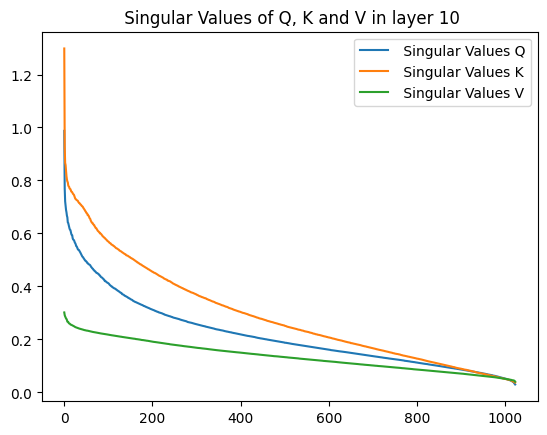

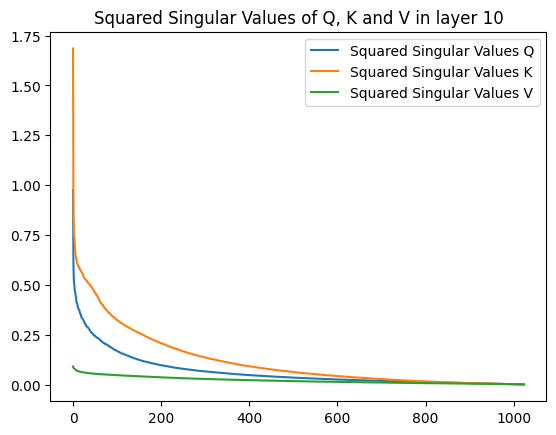

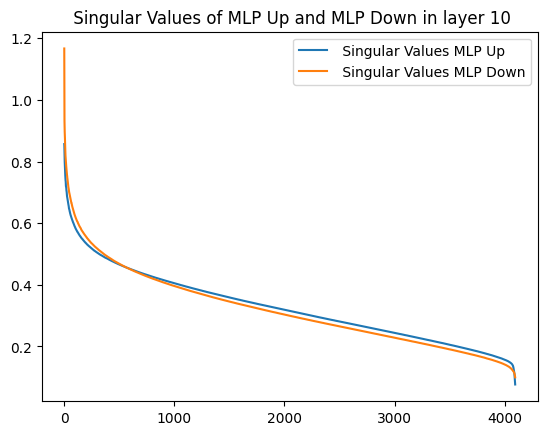

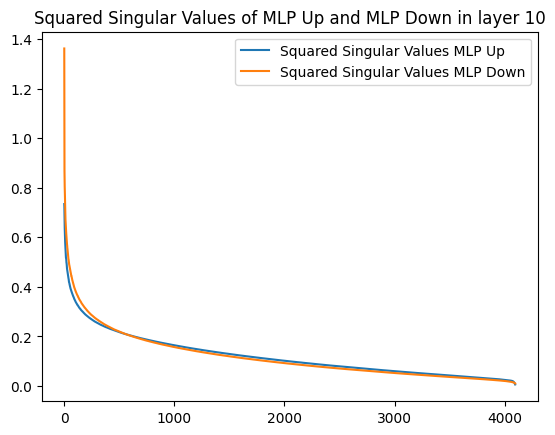

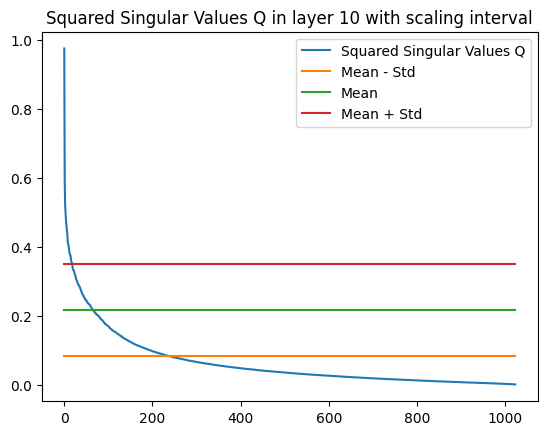

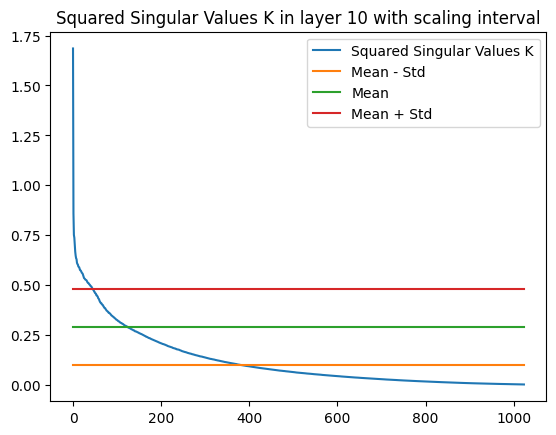

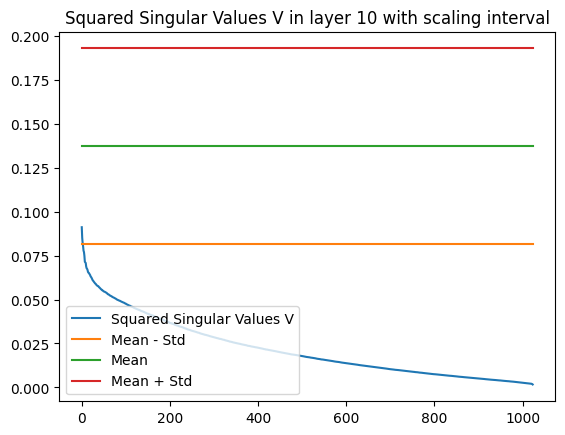

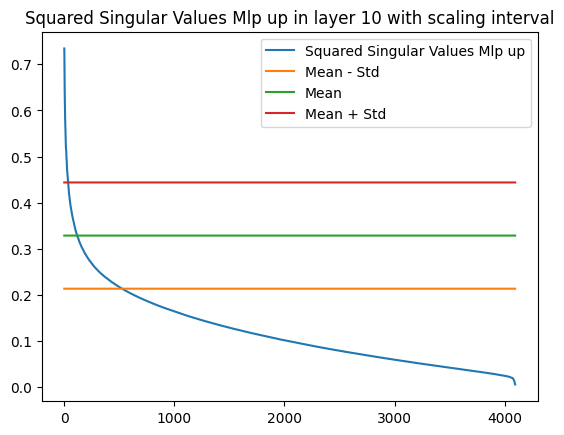

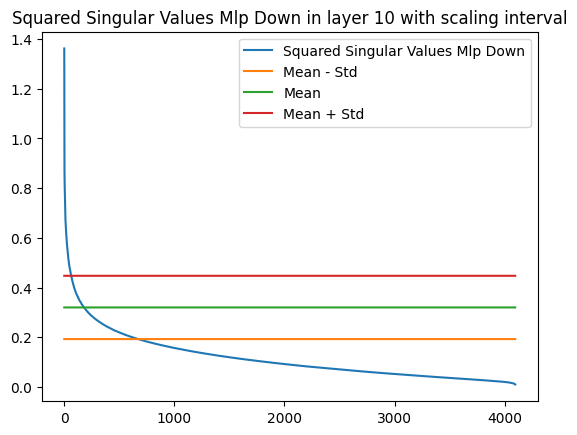

In [11]:
l = 10
num_layers, num_heads = 32, 8
print(f"Spectral Statistics Layer {l}")
alpha = 1
beta = 0
std = 0.02
embedding_dim, target_dimension = 4096, 1024
upscaling_dim = 14336


q_matrix_0, k_matrix_0, v_matrix_0 = get_qkv_matrix_from_layer_l(model, l)
q_matrix_0 = q_matrix_0[0 * target_dimension:1 * target_dimension, :] #Group query attention (complicated but get just first of 4 slices)

mlp_up_matrix_0, mlp_down_matrix_0 = get_mlp_up_down_matrix_from_layer_l(model, l)

print(q_matrix_0.shape, k_matrix_0.shape, v_matrix_0.shape, mlp_up_matrix_0.shape, mlp_down_matrix_0.shape)

print("Var Q", torch.var(q_matrix_0).item()) # intial var 0.0004, std 0.02
print("Var K", torch.var(k_matrix_0).item())
print("Var V", torch.var(v_matrix_0).item())
print("Var Mlp Up", torch.var(mlp_up_matrix_0).item())
print("Var Mlp Down", torch.var(mlp_down_matrix_0).item())

U1, D1, Vh1 = torch.svd(q_matrix_0) #initial var 1/2500 * 1/1.28 * 1/1.28
#print(torch.matmul(U1, torch.matmul(torch.diag(D1), Vh1.T)))
U2, D2, Vh2 = torch.svd(k_matrix_0)
U3, D3, Vh3 = torch.svd(v_matrix_0)
D4 = torch.linalg.svdvals(mlp_up_matrix_0)
D5 = torch.linalg.svdvals(mlp_down_matrix_0)


k_largest_components = 10

print("Shape Trace Q^TK", torch.matmul(q_matrix_0.T, k_matrix_0).shape)
print("Hypothetical Trace Var", 0.02 * 0.02 * embedding_dim)
print("Trace Q^T*K", torch.trace(torch.matmul(q_matrix_0, k_matrix_0.T)).item())
print("Expected Var", k_largest_components)
print("Trace U1^T*U2", torch.trace(torch.matmul(U1[:k_largest_components].T, U2[:k_largest_components])).item())
print("Trace V1^T*U2", torch.trace(torch.matmul(Vh1[:k_largest_components].T, Vh2[:k_largest_components])).item())

#print("Trace Difference U1 U2", torch.trace(torch.matmul(U1.T, U2)).item())
#print("Trace Difference V1 V2", torch.trace(torch.matmul(Vh1.T, Vh2)).item())

print_singular_value_statistics(D1, "Q")
print_singular_value_statistics(D2, "K")
print_singular_value_statistics(D3, "V")
print_singular_value_statistics(D4, "Mlp Up")
print_singular_value_statistics(D5, "Mlp Down")

# n = 1024, m = 4096, std = 0.02
# Formula largest singular value: (1 + sqrt(m/n)) * std * np.sqrt(n)
# Formula largest Squared singular value: (1 + sqrt(m/n)) ** 2 * std** 2 * n
# Formula Average Squared Singular Value (m / n) * n * std ** 2

print_singular_value_statistics(D1, "Q") #0.071 for layer 0
print_singular_value_statistics(D2, "K")
print_singular_value_statistics(D3, "V")
plot_singular_values_q_k_v(D1, D2, D3, l)
plot_singular_values_mlp_up_down(D4, D5, l)

plot_singular_values_squared_with_scaling_interval(D1, "Q", l)
plot_singular_values_squared_with_scaling_interval(D2, "K", l)
plot_singular_values_squared_with_scaling_interval(D3, "V", l)
plot_singular_values_squared_with_scaling_interval(D4, "Mlp up", l)
plot_singular_values_squared_with_scaling_interval(D5, "Mlp Down", l)

In [16]:
#plot_singular_values_statistics(model, num_layers)
plot_singular_values_statistics_up_down(model, num_layers)

Extracting Layer 0
Extracting Layer 1


KeyboardInterrupt: 

In [86]:
def get_embedding():
        for name, param in model.named_parameters():
            if name == "model.embed_tokens.weight":
                return param
            
def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
def entropy(v):
    return -np.sum(v * np.log(v))

def KL_divergence(p, q):
    return np.sum(p * np.log(p / q))

def jensen_difference(p, q):
    m = (p + q) / 2
    return KL_divergence(p, m) / 2 + KL_divergence(q, m) / 2

def calculate_embeddings_stats():

    embedding = get_embedding()
    vocab_size, embedding_size = embedding.shape[0], embedding.shape[1]
    k = 0
    lengths = []
    entropies1 = []
    entropies2 = []
    


    for i in range(vocab_size):
        length = torch.linalg.norm(embedding[i]).item()
        if length > 0:
            k += 1
            lengths.append(length)
            embedding_i = softmax(embedding[i].cpu().detach().numpy())
            embedding_i = embedding_i / np.linalg.norm(embedding_i) * 1.27993
            entropies1.append(entropy(softmax(embedding_i)))
            v = np.random.normal(0, 1, embedding_size)
            v = v / np.linalg.norm(v) * 1.27993
            entr = entropy(softmax(v))
            entropies2.append(entr)


    print(k, " embeddings out of ", vocab_size, " are not zero vectors") #31859 nonzero embedding vectors
    print("Average length: ", np.mean(lengths))
    print("Var length: ", np.var(lengths))
    print("Average entropy: ", np.mean(entropies1))
    print("Var entropy: ", np.var(entropies1))
    print("Average entropy: ", np.mean(entropies2))
    print("Var entropy: ", np.var(entropies2))
    print("Balanced Entropy", entropy(np.ones(embedding_size) / embedding_size))
    print("Largest Singular Values Q ", D1[0:20])
    print("Largest Singular Values K", D1[0:20])

seq = "Seal Claps on land, swims in seas"
encoded_seq = tokenizer.encode(seq)
decoded_seq = tokenizer.decode(encoded_seq)
decoded_seq = decoded_seq.replace("<s> ", "")

embedding = get_embedding()
embeddings = []
for token in encoded_seq:
    embeddings.append(embedding[token])

for i in range(1, len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        if i == j:
            continue
        embedding_i = embeddings[i].cpu().detach().numpy()
        embedding_j = embeddings[j].cpu().detach().numpy()
        print(entropy(softmax(embedding_i)))
        print(jensen_difference(softmax(embedding_i), softmax(embedding_j)))
        decoded_i = tokenizer.decode(encoded_seq[i])
        decoded_j = tokenizer.decode(encoded_seq[j])
        print("Tokens: ", decoded_i, decoded_j, "Similarity: ", 
              np.dot(embedding_i, embedding_j) / (np.linalg.norm(embedding_i) * np.linalg.norm(embedding_j)))


def find_closest_embeddings(word, embedding, threshold = 0.15):
    token = tokenizer.encode(word)[1]
    token_embedding = embedding[token]
    similarities = []
    for i in range(embedding.shape[0]):
        other_embedding = embedding[i]
        if torch.linalg.norm(other_embedding) == 0:
            continue
        similarity = torch.dot(token_embedding, other_embedding) / (torch.linalg.norm(token_embedding) * torch.linalg.norm(other_embedding))
        if similarity > threshold and i != token:
            similarities.append((i, similarity.item()))
    
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    for i, similarity in similarities:
        print(tokenizer.decode(i), similarity)

print(encoded_seq, decoded_seq)
find_closest_embeddings("I", embedding)
#calculate_embeddings_stats()

8.317763
1.0008029676100705e-06
Tokens:  Se al Similarity:  0.018645044
8.317763
1.2302809864195297e-06
Tokens:  Se Cl Similarity:  0.14572115
8.317763
1.288618932449026e-06
Tokens:  Se aps Similarity:  0.014862939
8.317763
1.0512899280001875e-06
Tokens:  Se on Similarity:  0.007480316
8.317763
1.386536951031303e-06
Tokens:  Se land Similarity:  0.0068196417
8.317763
9.348555067845155e-07
Tokens:  Se , Similarity:  0.029217156
8.317763
1.3761707577941706e-06
Tokens:  Se sw Similarity:  0.048058603
8.317763
1.4797237781749573e-06
Tokens:  Se ims Similarity:  0.008087092
8.317763
1.0157559700019192e-06
Tokens:  Se in Similarity:  0.0129186185
8.317763
1.6104393125715433e-06
Tokens:  Se seas Similarity:  0.11312101
8.317765
1.0307647357876704e-06
Tokens:  al Cl Similarity:  0.028104847
8.317765
8.578530241720728e-07
Tokens:  al aps Similarity:  0.08079993
8.317765
6.428591632356984e-07
Tokens:  al on Similarity:  0.051972
8.317765
9.673267413745634e-07
Tokens:  al land Similarity:  0.0499